## Loading and cleaning data

In [1]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage


# Load data from zip file
zip_path = "data/dmc_122124.zip"
zip_path = "data/dmc_122724.zip"
zip_path = "data/dmc_010225.zip"
records = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for filename in zip_ref.namelist():
        if filename.endswith('.npy'):
            # Extract parameters from directory name (e.g. BRO_64_1_3e-4)
            env_name = filename.split('/')[2].split('.')[0]  # Get environment name from path
            name = filename.split('/')[1]
            params = name.split('_')
            batch_size = int(params[1])
            utd = int(params[2])
            learning_rate = float(params[3])
            # Load array data
            with zip_ref.open(filename) as f:
                arr = np.load(f)
                
            # Create record with metadata and results
            records.append({ 
                'env_name': env_name,
                'batch_size': batch_size,
                'utd': utd,
                'learning_rate': learning_rate,
                'training_step': arr[:, 0],
                'return': arr[:, 1:],
                'mean_return': np.mean(arr[:, 1:], axis=1),  # Add summary statistics
                # 'return': arr[:, 1:7],
                # 'mean_return': np.mean(arr[:, 1:7], axis=1),
                'std_return': np.std(arr[:, 1:7], axis=1) / np.sqrt(10)  # Standard Error of Mean over 10 seeds
            })

# Convert to pandas DataFrame
df = pd.DataFrame(records)

df['learning_rate'] = df['learning_rate'].replace(1.2e-2, 1.2e-3) # mislabeled in the data

# Add isotonic regression on return data
from sklearn.isotonic import IsotonicRegression
iso_reg_results = []

for _, row in df.iterrows():
    # Initialize isotonic regression model
    ir = IsotonicRegression(out_of_bounds='clip')
    
    # Fit on training steps and mean returns
    x = row['training_step']
    y = row['mean_return']
    # Bootstrap sampling from returns
    # Sample with replacement from the returns at each timestep
    # bootstrap_samples = np.random.choice(row['return'].shape[1], size=row['return'].shape[1], replace=True)
    # y = np.mean(row['return'][:, bootstrap_samples], axis=1)
    # print(row['mean_return'].shape, row['return'].shape)
    
    # Fit the model and get predictions
    ir.fit(x, y)
    y_iso = ir.predict(x)
    
    iso_reg_results.append(y_iso)

# Add isotonic regression results to dataframe    
df['return_isotonic'] = iso_reg_results

# Calculate crossings for each threshold and store in array
thresholds = [100, 200, 300, 400, 500, 600, 700, 800]

crossings_array = []

for _, row in df.iterrows():
    row_crossings = []
    
    for threshold in thresholds:
        # Get crossing from isotonic regression
        crossing_idx = np.where(row['return_isotonic'] > threshold)[0]
        row_crossings.append(row['training_step'][crossing_idx[0]] if len(crossing_idx) > 0 else np.nan)
    
    crossings_array.append(row_crossings)

df['crossings'] = crossings_array


# df

In [2]:
# add error bars via bootstrap

iso_reg = []
iso_reg_stds = []
crossings = []
crossings_std = []
for _, row in df.iterrows():    
    n_bootstrap = 100  # Number of bootstrap samples. 100 seems enough for std to converge
    ir = IsotonicRegression(out_of_bounds='clip')
    x = row['training_step']
    y_iso_samples = []
    sample_crossings = []
    for _ in range(n_bootstrap):
        # Sample with replacement
        sample_indices = np.random.randint(0, row['return'].shape[1], size=row['return'].shape[1])
        y = np.mean(row['return'][:, sample_indices], axis=1)  # Average the bootstrap samples
        
        # Fit isotonic regression on this bootstrap sample
        ir.fit(x, y)
        y_iso = ir.predict(x)
        y_iso_samples.append(y_iso)

        # For each bootstrap sample, find threshold crossings
        sample_crossing = []
        for threshold in thresholds:
            crossing_idx = np.where(y_iso > threshold)[0]
            crossing = row['training_step'][crossing_idx[0]] if len(crossing_idx) > 0 else np.nan
            sample_crossing.append(crossing)
        sample_crossings.append(sample_crossing)
    
    # Store mean prediction, crossing statistics, and isotonic std
    iso_reg.append(y_iso_samples)
    crossings.append(np.array(sample_crossings))
    crossings_std.append(np.nanstd(sample_crossings, axis=0))
    iso_reg_stds.append(np.std(y_iso_samples, axis=0))

df['return_isotonic_bootstrap'] = iso_reg
df['crossings_bootstrap'] = crossings
df['crossings_std'] = crossings_std
df['return_isotonic_std'] = iso_reg_stds

mean_std = np.nanmean(np.array(crossings_std))
print(f"Average standard deviation across all conditions: {mean_std:.2f}")







/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/oleh

Average standard deviation across all conditions: 10930.33


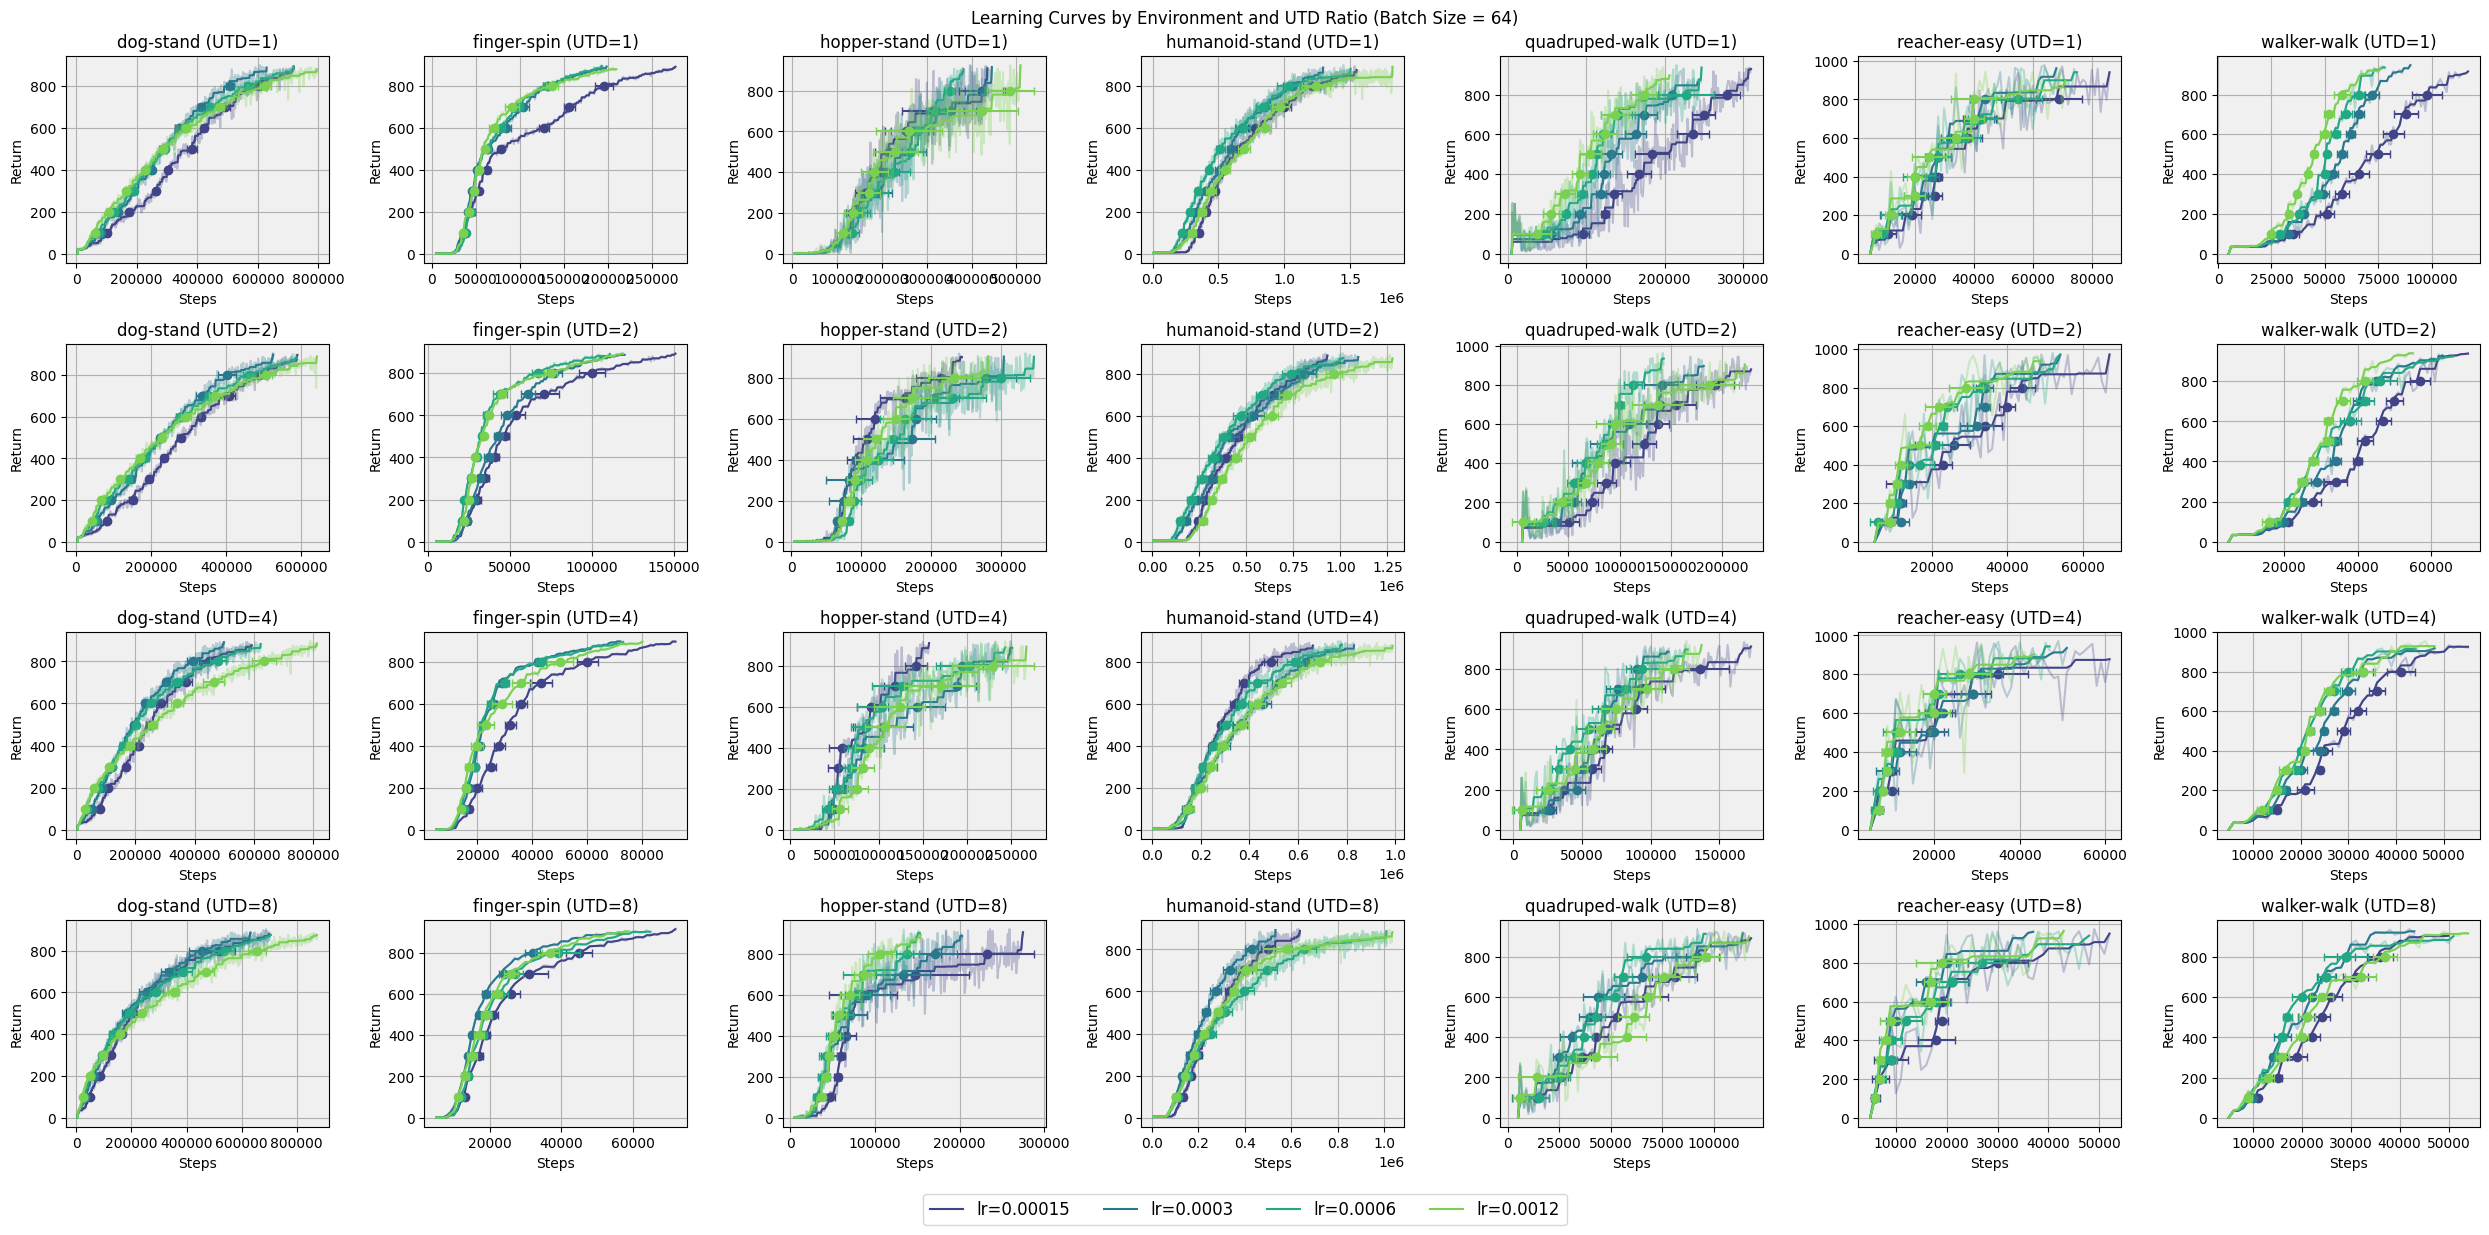

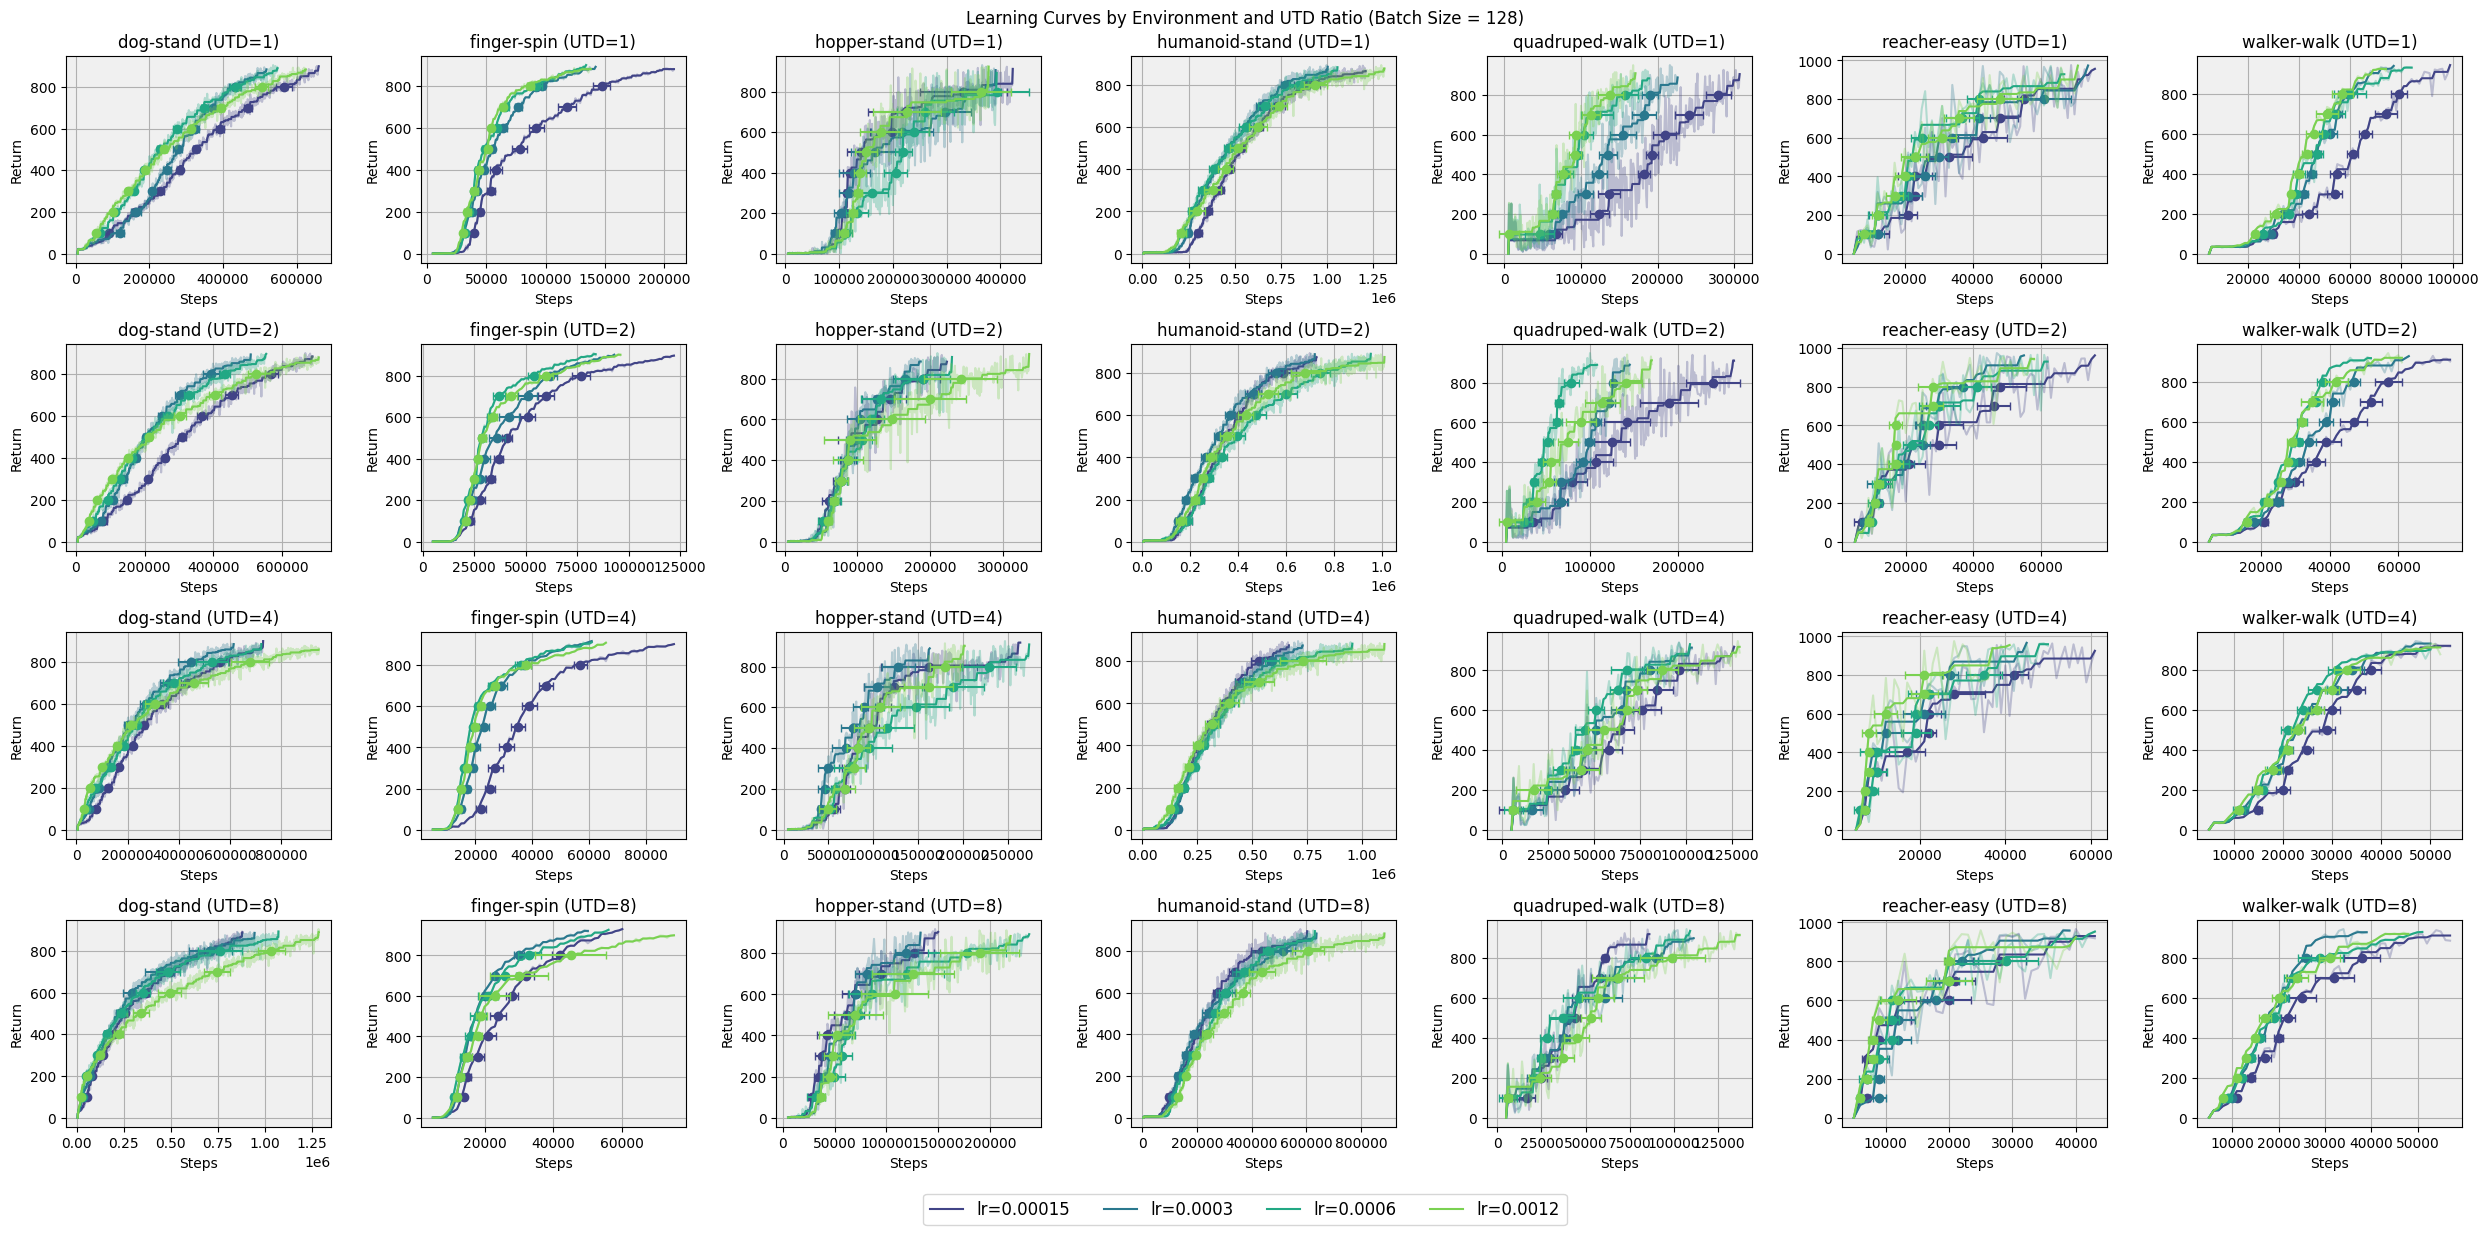

/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1066: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/matplotlib/axes/_axes.py:1067: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


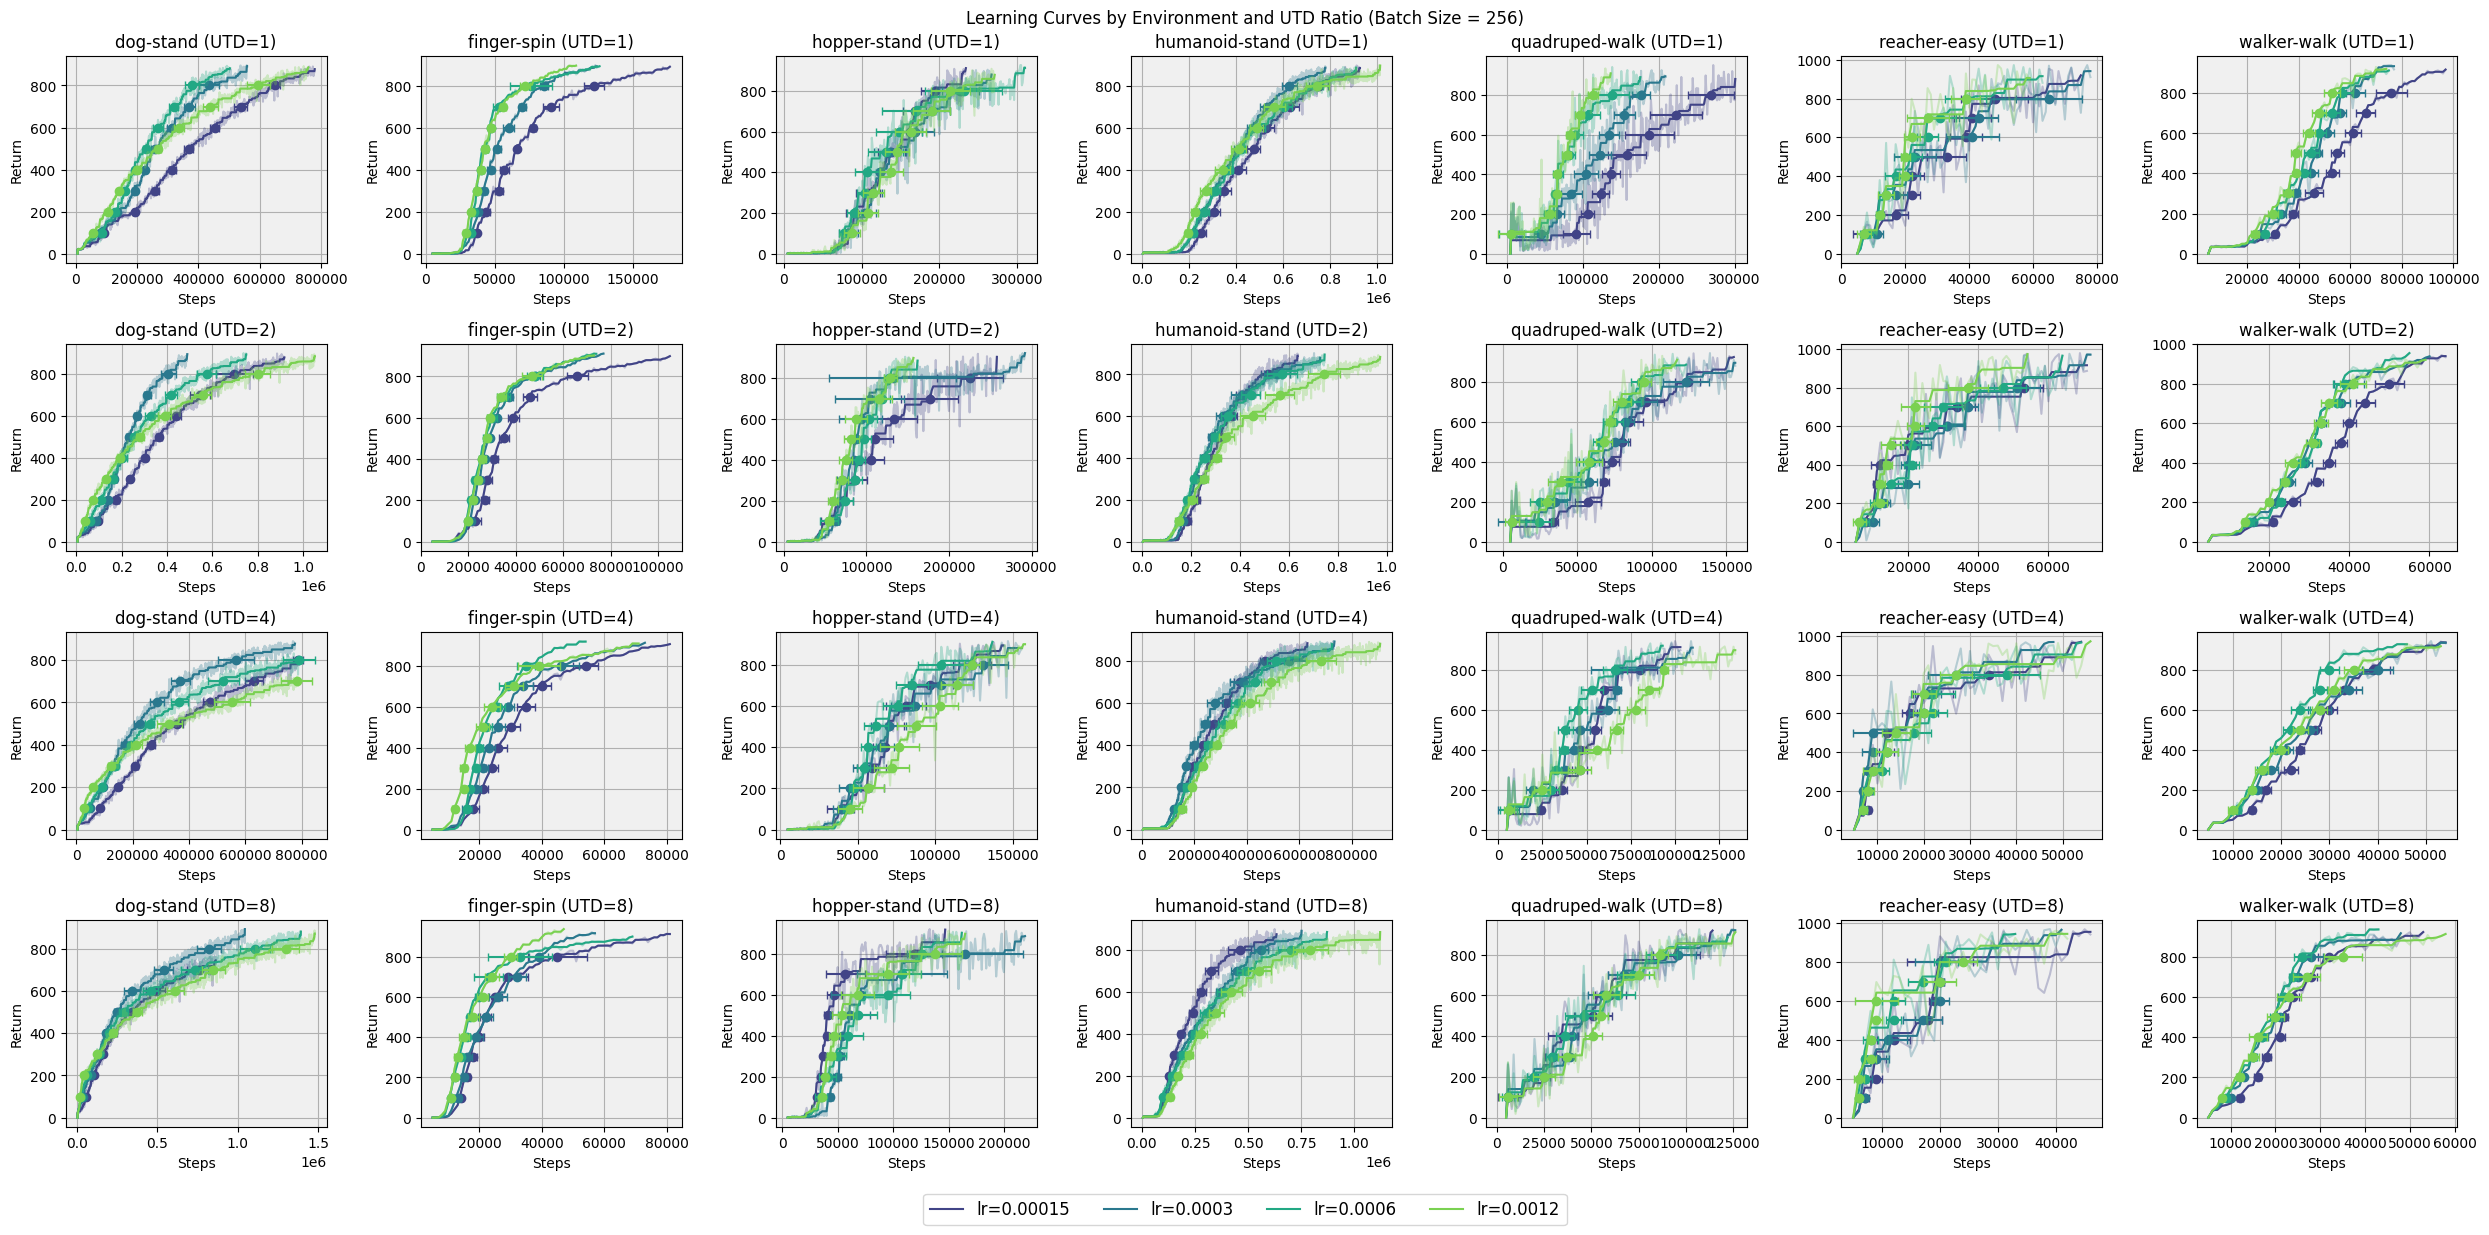

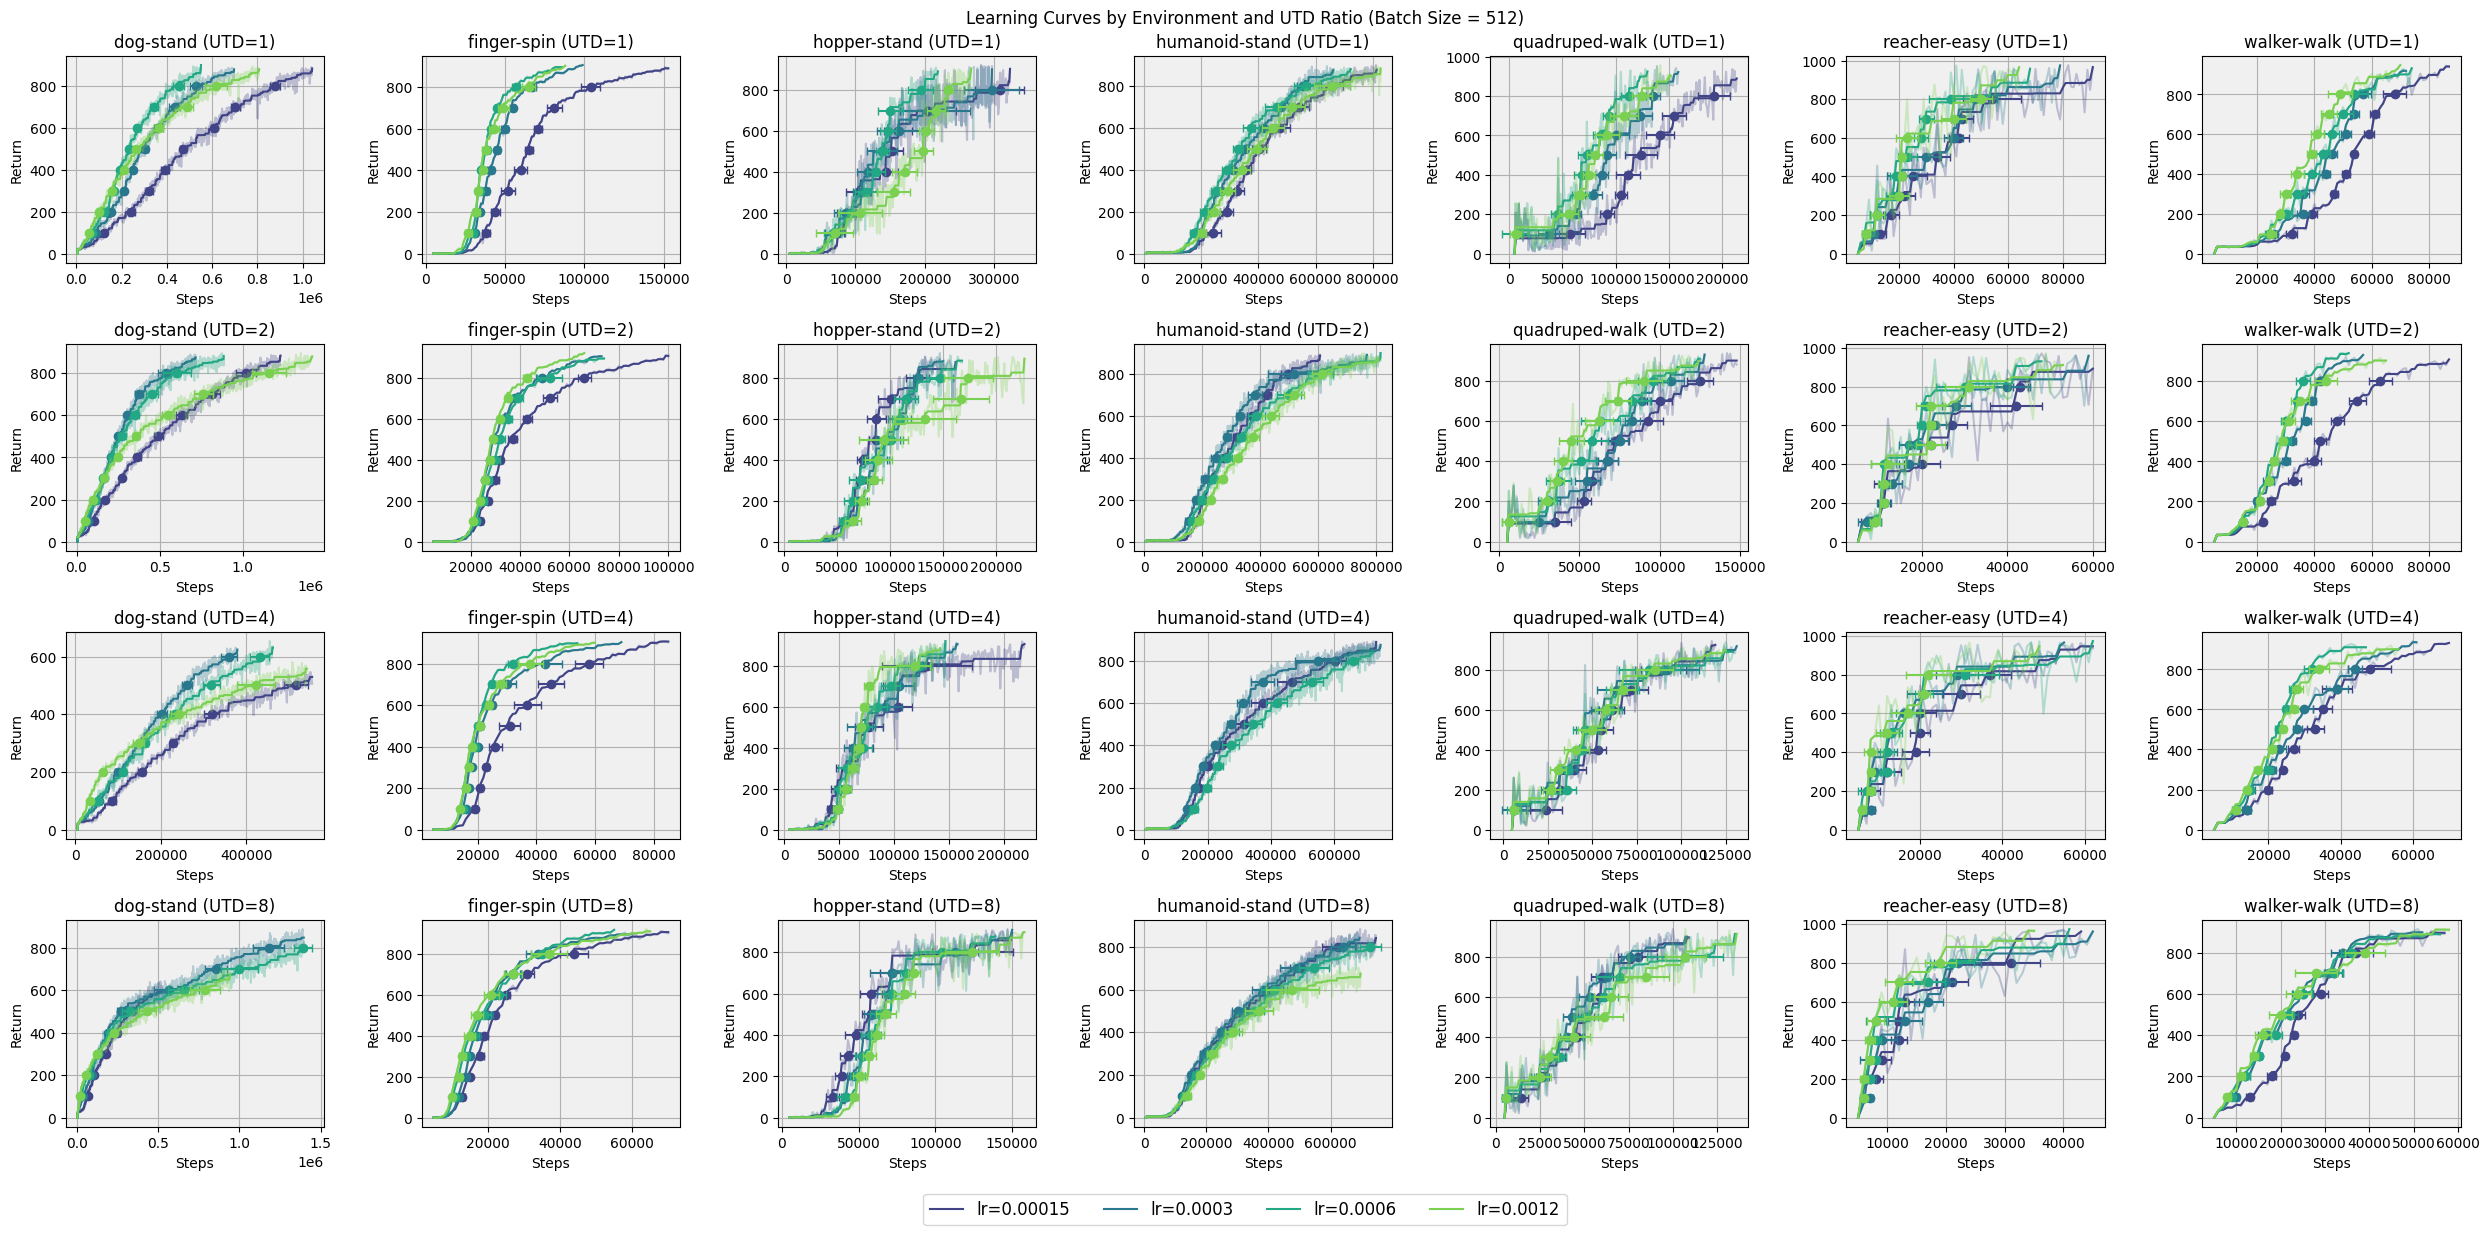

In [3]:
# plot curves

import matplotlib.pyplot as plt
import seaborn as sns

# Get unique batch sizes
batch_sizes = sorted(df['batch_size'].unique())

# Create a separate plot for each batch size
for batch_size in batch_sizes:
    colors = sns.color_palette("viridis", n_colors=4)  # Using viridis for a nice gradient
    fig, axs = plt.subplots(4, 7, figsize=(25, 12))
    fig.suptitle(f'Learning Curves by Environment and UTD Ratio (Batch Size = {batch_size})')

    lines = []
    labels = []
    config_colors = {}
    color_idx = 0

    # Filter data for current batch size
    df_filtered = df[df['batch_size'] == batch_size]

    # Group data by environment and UTD ratio
    for i, env in enumerate(sorted(df['env_name'].unique())):
        env_data = df_filtered[df_filtered['env_name'] == env]
        
        # Create separate plots for each UTD value
        for j, utd in enumerate(sorted(env_data['utd'].unique())):
            utd_data = env_data[env_data['utd'] == utd]
            # Sort by learning rate only since we're already filtering by UTD
            utd_data = utd_data.sort_values('learning_rate')
            
            ax = axs[j, i]
            ax.set_title(f'{env} (UTD={utd})')
            
            for _, row in utd_data.iterrows():
                config = row['learning_rate']
                if config not in config_colors:
                    config_colors[config] = color_idx
                    color_idx += 1
                
                label = f"lr={row['learning_rate']}"
                line = ax.plot(row['training_step'], row['mean_return'], alpha=0.3, color=colors[config_colors[config] % len(colors)])
                line = ax.plot(row['training_step'], row['return_isotonic'], alpha=1, color=colors[config_colors[config] % len(colors)])
                # results = scipy.ndimage.gaussian_filter1d(row['mean_return'], smoothing[env, row['utd']])
                # line = ax.plot(row['training_step'], results, alpha=1, color=colors[config_colors[config] % len(colors)])
                
                # use the crossings column to plot crossings
                for k, threshold in enumerate(thresholds):
                    # crossing_x = row['crossings'][k]
                    crossing_x = row['crossings'][k]
                    crossing_y = threshold
                    ax.plot(crossing_x, crossing_y, 'o', color=colors[config_colors[config] % len(colors)])
                # Plot crossing standard deviations as error bars
                for k, threshold in enumerate(thresholds):
                    crossing_x = row['crossings'][k]
                    crossing_y = threshold
                    crossing_std = row['crossings_std'][k]
                    ax.errorbar(crossing_x, crossing_y, xerr=crossing_std, fmt='none', color=colors[config_colors[config] % len(colors)], capsize=3)

                # Only add to legend if we haven't seen this combination before
                if label not in labels:
                    lines.append(line[0])
                    labels.append(label)
            
            ax.set_xlabel('Steps')
            ax.set_ylabel('Return')
            ax.grid(True)
            
            # Set background color
            ax.set_facecolor('#f0f0f0')

    # Sort labels by learning rate
    sorted_indices = [i for i, _ in sorted(enumerate(labels), 
                                         key=lambda x: float(x[1].replace("lr=","")))]
    lines = [lines[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices]

    # Create a single legend outside all subplots
    fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels)), fontsize=12)
    plt.tight_layout()
    plt.show()

In [7]:
# # plot curves one figure per UTD

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Get unique UTD values
# utd_values = sorted(df['utd'].unique())

# # Create a separate plot for each UTD value
# for utd in utd_values:
#     colors = sns.color_palette("viridis", n_colors=4)  # Using viridis for a nice gradient
#     fig, axs = plt.subplots(4, 7, figsize=(25, 12))
#     fig.suptitle(f'Learning Curves by Environment and Batch Size (UTD = {utd})')

#     lines = []
#     labels = []
#     config_colors = {}
#     color_idx = 0

#     # Filter data for current UTD
#     df_filtered = df[df['utd'] == utd]

#     # Group data by environment and batch size
#     for i, env in enumerate(sorted(df['env_name'].unique())):
#         env_data = df_filtered[df_filtered['env_name'] == env]
        
#         # Create separate plots for each batch size value
#         for j, batch_size in enumerate(sorted(env_data['batch_size'].unique())):
#             batch_data = env_data[env_data['batch_size'] == batch_size]
#             # Sort by learning rate only since we're already filtering by batch size
#             batch_data = batch_data.sort_values('learning_rate')
            
#             ax = axs[j, i]
#             ax.set_title(f'{env} (BS={batch_size})')
            
#             for _, row in batch_data.iterrows():
#                 config = row['learning_rate']
#                 if config not in config_colors:
#                     config_colors[config] = color_idx
#                     color_idx += 1
                
#                 label = f"lr={row['learning_rate']}"
#                 line = ax.plot(row['training_step'], row['mean_return'], alpha=0.3, color=colors[config_colors[config] % len(colors)])
#                 line = ax.plot(row['training_step'], row['return_isotonic'], alpha=1, color=colors[config_colors[config] % len(colors)])
#                 # results = scipy.ndimage.gaussian_filter1d(row['mean_return'], smoothing[env, row['utd']])
#                 # line = ax.plot(row['training_step'], results, alpha=1, color=colors[config_colors[config] % len(colors)])
                
#                 # use the crossings column to plot crossings
#                 for k, threshold in enumerate(thresholds):
#                     # crossing_x = row['crossings'][k]
#                     crossing_x = row['crossings'][k]
#                     crossing_y = threshold
#                     ax.plot(crossing_x, crossing_y, 'o', color=colors[config_colors[config] % len(colors)])
#                 # Plot crossing standard deviations as error bars
#                 for k, threshold in enumerate(thresholds):
#                     crossing_x = row['crossings'][k]
#                     crossing_y = threshold
#                     crossing_std = row['crossings_std'][k]
#                     ax.errorbar(crossing_x, crossing_y, xerr=crossing_std, fmt='none', color=colors[config_colors[config] % len(colors)], capsize=3)

#                 # Only add to legend if we haven't seen this combination before
#                 if label not in labels:
#                     lines.append(line[0])
#                     labels.append(label)
            
#             ax.set_xlabel('Steps')
#             ax.set_ylabel('Return')
#             ax.grid(True)
            
#             # Set background color
#             ax.set_facecolor('#f0f0f0')

#     # Sort labels by learning rate
#     sorted_indices = [i for i, _ in sorted(enumerate(labels), 
#                                          key=lambda x: float(x[1].replace("lr=","")))]
#     lines = [lines[i] for i in sorted_indices]
#     labels = [labels[i] for i in sorted_indices]

#     # Create a single legend outside all subplots
#     fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels)), fontsize=12)
#     plt.tight_layout()
#     plt.show()

In [52]:
# # plot curves for all bs and lr together

# colors = sns.color_palette("viridis", n_colors=8)  # Using viridis for a nice gradient
# fig, axs = plt.subplots(4, 7, figsize=(25, 12))
# fig.suptitle('Learning Curves by Environment and UTD Ratio')

# lines = []
# labels = []
# config_colors = {}
# color_idx = 0

# df_filtered = df[df['batch_size'] == 64]
# df_filtered = df
# # df_filtered = df_filtered[df_filtered['learning_rate'] == 3e-4]

# # Group data by environment and UTD ratio
# for i, env in enumerate(df['env_name'].unique()):
#     env_data = df_filtered[df_filtered['env_name'] == env]
    
#     # Create separate plots for each UTD value
#     for j, utd in enumerate(env_data['utd'].unique()):
#         utd_data = env_data[env_data['utd'] == utd]
#         # Sort by batch size and learning rate
#         utd_data = utd_data.sort_values(['utd', 'batch_size', 'learning_rate'])
        
#         ax = axs[j, i]
#         ax.set_title(f'{env} (UTD={utd})')
        
#         for _, row in utd_data.iterrows():
#             config = (row['batch_size'], row['learning_rate'])
#             if config not in config_colors:
#                 config_colors[config] = color_idx
#                 color_idx += 1
            
#             label = f"bs={row['batch_size']}, lr={row['learning_rate']}"
#             line = ax.plot(row['training_step'], row['mean_return'], alpha=0.3, color=colors[config_colors[config] % len(colors)])
#             line = ax.plot(row['training_step'], row['return_isotonic'], alpha=1, color=colors[config_colors[config] % len(colors)])
#             # results = scipy.ndimage.gaussian_filter1d(row['mean_return'], smoothing[env, row['utd']])
#             # line = ax.plot(row['training_step'], results, alpha=1, color=colors[config_colors[config] % len(colors)])

#             # use the crossings column to plot crossings
#             # for k, threshold in enumerate(thresholds):
#             #     crossing_x = row['crossings'][k]
#             #     crossing_y = threshold
#             #     ax.plot(crossing_x, crossing_y, 'o', color=colors[config_colors[config] % len(colors)])
            
#             # Only add to legend if we haven't seen this combination before
#             if label not in labels:
#                 lines.append(line[0])
#                 labels.append(label)
        
#         ax.set_xlabel('Steps')
#         ax.set_ylabel('Return')
#         ax.grid(True)
        
#         # Set background color
#         ax.set_facecolor('#f0f0f0')

# # Sort labels by batch size and learning rate
# sorted_indices = [i for i, _ in sorted(enumerate(labels), 
#                                      key=lambda x: tuple(map(float, x[1].replace("bs=","").replace("lr=","").split(", "))))]
# lines = [lines[i] for i in sorted_indices]
# labels = [labels[i] for i in sorted_indices]

# # Create a single legend outside all subplots
# fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels) // 3)+1, fontsize=12)
# plt.tight_layout()
# plt.show()

In [4]:
# # plot curves, split by learning rate

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Get unique learning rates
# learning_rates = df['learning_rate'].unique()

# # Create a separate plot for each learning rate
# for lr in learning_rates:
#     colors = sns.color_palette("viridis", n_colors=4)  # Using viridis for a nice gradient
#     fig, axs = plt.subplots(4, 7, figsize=(25, 12))
#     fig.suptitle(f'Learning Curves by Environment and UTD Ratio (Learning Rate = {lr})')

#     lines = []
#     labels = []
#     config_colors = {}
#     color_idx = 0

#     # Filter data for current learning rate
#     df_filtered = df[df['learning_rate'] == lr]

#     # Group data by environment and UTD ratio
#     for i, env in enumerate(df['env_name'].unique()):
#         env_data = df_filtered[df_filtered['env_name'] == env]
        
#         # Create separate plots for each UTD value
#         for j, utd in enumerate(sorted(env_data['utd'].unique())):
#             utd_data = env_data[env_data['utd'] == utd]
#             # Sort by UTD
#             utd_data = utd_data.sort_values('batch_size')
            
#             ax = axs[j, i]
#             ax.set_title(f'{env} (UTD={utd})')
            
#             for _, row in utd_data.iterrows():
#                 config = row['batch_size']
#                 if config not in config_colors:
#                     config_colors[config] = color_idx
#                     color_idx += 1
                
#                 label = f"batch_size={row['batch_size']}"
#                 # Plot raw data with low alpha
#                 line = ax.plot(row['training_step'], row['mean_return'], alpha=0.3, color=colors[config_colors[config] % len(colors)])
#                 # Plot isotonic regression with full alpha
#                 line = ax.plot(row['training_step'], row['return_isotonic'], alpha=1, color=colors[config_colors[config] % len(colors)])

#                 # use the crossings column to plot crossings
#                 for k, threshold in enumerate(thresholds):
#                     crossing_x = row['crossings'][k]
#                     crossing_y = threshold
#                     ax.plot(crossing_x, crossing_y, 'o', color=colors[config_colors[config] % len(colors)])
                
#                 # Only add to legend if we haven't seen this combination before
#                 if label not in labels:
#                     lines.append(line[0])
#                     labels.append(label)
            
#             ax.set_xlabel('Steps')
#             ax.set_ylabel('Return')
#             ax.grid(True)
            
#             # Set background color
#             ax.set_facecolor('#f0f0f0')

#     # Sort labels by batch size
#     sorted_indices = [i for i, _ in sorted(enumerate(labels), 
#                                          key=lambda x: float(x[1].replace("batch_size=","")))]
#     lines = [lines[i] for i in sorted_indices]
#     labels = [labels[i] for i in sorted_indices] 

#     # Create a single legend outside all subplots
#     fig.legend(lines, labels, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=(len(labels)), fontsize=12)
#     plt.tight_layout()
#     plt.show()

In [54]:
# # Plot learning rate vs performance for each environment, batch size and UTD
# unique_envs = sorted(df['env_name'].unique())
# unique_batch_sizes = sorted(df['batch_size'].unique()) 
# unique_utds = sorted(df['utd'].unique())

# for env in unique_envs:
#     # Create a new figure for each environment
#     cols = 4
#     rows = int(np.ceil(len(unique_batch_sizes) * len(unique_utds) / cols))
#     fig, axs = plt.subplots(rows, cols, figsize=(15, 3*rows))
#     axs = axs.flatten()
    
#     plot_idx = 0
#     env_data = df[df['env_name'] == env]
    
#     for utd in unique_utds:
#         for batch_size in unique_batch_sizes:
#             data = env_data[(env_data['batch_size'] == batch_size) & 
#                            (env_data['utd'] == utd)]
            
#             if len(data) == 0:
#                 continue
                
#             # Group by learning rate
#             lr_groups = data.groupby('learning_rate')
#             threshold_i = -1
#             threshold = thresholds[threshold_i]

#             time_to_threshold = lr_groups.apply(lambda x: np.mean([r[threshold_i] for r in x['crossings']]))
#             sem = lr_groups.apply(lambda x: np.mean([r[threshold_i] for r in x['crossings_std']]))
            
#             lrs = sorted(lr_groups.groups.keys())
#             means = [time_to_threshold[lr] for lr in lrs]
#             sems = [sem[lr] for lr in lrs]
            
#             axs[plot_idx].errorbar(lrs, means, yerr=sem, fmt='o-')
            
#             axs[plot_idx].set_xscale('log')
#             axs[plot_idx].set_xlabel('Learning Rate')
#             axs[plot_idx].set_ylabel('Time to {threshold}')
#             axs[plot_idx].set_title(f'batch_size={batch_size}, utd={utd}')
#             axs[plot_idx].grid(True)
            
#             plot_idx += 1
    
#     # Remove empty subplots
#     for i in range(plot_idx, len(axs)):
#         fig.delaxes(axs[i])
        
#     fig.suptitle(env, fontsize=16)
#     plt.tight_layout()
#     plt.show()


## Optimal learning rate and batch size 

In [4]:
# make and print a table with best learning rate for each environment, batch size and UTD
# with environment as rows and utd x batch size as columns

# Group data by environment, batch size and UTD
grouped = df.groupby(['env_name', 'batch_size', 'utd'])

# Find best learning rate for each group
results = []
for (env, bs, utd), group in grouped:
    threshold_i = -1
    # Group by learning rate and get time to threshold
    lr_groups = group.groupby('learning_rate')
    time_to_threshold = lr_groups.apply(lambda x: x['crossings'].iloc[0][threshold_i]).dropna()
    
    # Get bootstrap samples
    time_to_threshold_bs = lr_groups.apply(lambda x: x['crossings_bootstrap'].iloc[0][:, threshold_i])
    lrs = np.array(time_to_threshold_bs.index)
    times_bs = np.array(time_to_threshold_bs.tolist())
    
    # Find best learning rates
    times_bs_inf = np.where(np.isnan(times_bs), np.inf, times_bs)
    best_lr_bootstrap = lrs[np.argmin(times_bs_inf, axis=0)]
    best_times_bootstrap = np.min(times_bs_inf, axis=0)
    
    # Get point estimates
    best_lr = time_to_threshold.idxmin() if len(time_to_threshold) > 0 else None
    min_time = time_to_threshold[best_lr] if best_lr is not None else None

    results.append({
        'env_name': env,
        'batch_size': bs,
        'utd': utd,
        'best_lr': best_lr,
        'time_to_threshold': min_time,
        'best_lr_bootstrap': best_lr_bootstrap, # run learning rate selection 100 times and record best learning rate
        'time_to_threshold_bootstrap': best_times_bootstrap, # run learning rate selection 100 times and record corresponding time to threshold
    })

# Create DataFrame
df_best_lr = pd.DataFrame(results)

# Pivot table to get environments as rows and utd x batch_size as columns
pivot_df = df_best_lr.pivot_table(
    index='utd',
    columns=['env_name', 'batch_size'],
    values='best_lr',
    aggfunc='first'
)

# Print formatted table with scientific notation
pd.set_option('display.float_format', '{:.1e}'.format)
print("\nBest Learning Rates:")
print(pivot_df.to_string())

# now do the same for uncertainty-corrected best learning rates
# Create pivot table for uncertainty-corrected best learning rates
# Use mean of bootstrap samples as uncertainty-corrected estimate
pivot_df_bootstrap = df_best_lr.pivot_table(
    index='utd',
    columns=['env_name', 'batch_size'],
    values='best_lr_bootstrap',
    aggfunc=lambda x: np.mean(np.stack(x))
)

# Print formatted table with scientific notation
print("\nUncertainty-Corrected Best Learning Rates:")
print(pivot_df_bootstrap.to_string())






Best Learning Rates:
env_name   dog-stand                         finger-spin                         hopper-stand                         humanoid-stand                         quadruped-walk                         reacher-easy                         walker-walk                        
batch_size       64      128     256     512         64      128     256     512          64      128     256     512            64      128     256     512            64      128     256     512          64      128     256     512         64      128     256     512
utd                                                                                                                                                                                                                                                                         
1            3.0e-04 3.0e-04 6.0e-04 6.0e-04     6.0e-04 1.2e-03 1.2e-03 6.0e-04      6.0e-04 1.5e-04 1.5e-04 6.0e-04        6.0e-04 3.0e-04 3.0e-04 3.0e-04        1.2e-03

In [19]:
# Find best batch size for each env/utd/lr combination based on minimum time to threshold
best_bs_results = []
for (env, utd, lr), group in df.groupby(['env_name', 'utd', 'learning_rate']):
    # Drop any rows where crossings[-1] is None
    group = group.dropna(subset=['crossings'])
    
    if len(group) > 0:
        # Get the last crossing time for each row and bootstrap samples
        group['last_crossing'] = group['crossings'].apply(lambda x: x[-1] if len(x) > 0 else float('inf'))
        group['last_crossing_bootstrap'] = group['crossings_bootstrap'].apply(lambda x: x[:, -1])
        
        # Get batch sizes and times for bootstrap analysis
        batch_sizes = np.array(group['batch_size'])
        times_bs = np.stack(group['last_crossing_bootstrap'])
        
        # Find best batch sizes
        times_bs_inf = np.where(np.isnan(times_bs), np.inf, times_bs)
        best_bs_bootstrap = batch_sizes[np.argmin(times_bs_inf, axis=0)]
        best_times_bootstrap = np.min(times_bs_inf, axis=0)
        
        # Get point estimates
        best_bs = group.loc[group['last_crossing'].idxmin(), 'batch_size']
        min_time = group['last_crossing'].min()
        
        best_bs_results.append({
            'env_name': env,
            'utd': utd,
            'learning_rate': lr,
            'best_bs': best_bs,
            'time_to_threshold': min_time,
            'best_bs_bootstrap': best_bs_bootstrap,
            'time_to_threshold_bootstrap': best_times_bootstrap
        })

# Create DataFrame
df_best_bs = pd.DataFrame(best_bs_results)

# Pivot table to show best batch sizes by environment and UTD, with learning rates as columns
pivot_bs = df_best_bs.pivot_table(
    index=['utd'],
    columns=['env_name', 'learning_rate'],
    values='best_bs',
    aggfunc='first'
)

print("\nBest Batch Sizes:")
print(pivot_bs.to_string())

# Also show corresponding times to threshold
pivot_times = df_best_bs.pivot_table(
    index=['utd'],
    columns=['env_name', 'learning_rate'], 
    values='time_to_threshold',
    aggfunc='first'
)

print("\nCorresponding Times to Threshold:")
print(pivot_times.to_string())



Best Batch Sizes:
env_name      dog-stand                         finger-spin                         hopper-stand                         humanoid-stand                         quadruped-walk                         reacher-easy                         walker-walk                        
learning_rate   1.5e-04 3.0e-04 6.0e-04 1.2e-03     1.5e-04 3.0e-04 6.0e-04 1.2e-03      1.5e-04 3.0e-04 6.0e-04 1.2e-03        1.5e-04 3.0e-04 6.0e-04 1.2e-03        1.5e-04 3.0e-04 6.0e-04 1.2e-03      1.5e-04 3.0e-04 6.0e-04 1.2e-03     1.5e-04 3.0e-04 6.0e-04 1.2e-03
utd                                                                                                                                                                                                                                                                            
1                   128     128     256     128         512     512     512     512          256     256     512     256            512     512     512     512      

In [7]:
# # for each utd and env, plot best learning rate depending on batch size
# # Plot best learning rate vs batch size for each UTD and environment
# unique_envs = sorted(df['env_name'].unique())
# unique_utds = sorted(df['utd'].unique())

# fig, axs = plt.subplots(len(unique_utds), len(unique_envs), figsize=(25, 15))
# fig.suptitle('Best Learning Rate vs Batch Size')

# for i, env in enumerate(unique_envs):
#     for j, utd in enumerate(unique_utds):
#         env_data = df_best_lr[
#             (df_best_lr['env_name'] == env) & 
#             (df_best_lr['utd'] == utd)
#         ]
        
#         if len(env_data) > 0:
#             batch_sizes = env_data['batch_size']
#             best_lrs = env_data['best_lr']
            
#             axs[j, i].plot(batch_sizes, best_lrs, 'o-')
#             axs[j, i].set_xscale('log')
#             axs[j, i].set_yscale('log')
#             axs[j, i].set_ylim(1.3e-4, 1.3e-3)
#             axs[j, i].set_xlabel('Batch Size')
#             axs[j, i].set_ylabel('Best Learning Rate')
#             axs[j, i].set_title(f'{env}, UTD={utd}')
#             axs[j, i].grid(True)

# plt.tight_layout()
# plt.show()



In [8]:
# # Plot best learning rate vs UTD for each batch size and environment
# unique_envs = sorted(df['env_name'].unique())
# unique_batch_sizes = sorted(df['batch_size'].unique())

# fig, axs = plt.subplots(len(unique_batch_sizes), len(unique_envs), figsize=(25, 15))
# fig.suptitle('Best Learning Rate vs UTD')

# for i, env in enumerate(unique_envs):
#     for j, bs in enumerate(unique_batch_sizes):
#         env_data = df_best_lr[
#             (df_best_lr['env_name'] == env) & 
#             (df_best_lr['batch_size'] == bs)
#         ]
        
#         if len(env_data) > 0:
#             utds = env_data['utd']
#             best_lrs = env_data['best_lr']
            
#             axs[j, i].plot(utds, best_lrs, 'o-')
#             axs[j, i].set_xscale('log')
#             axs[j, i].set_yscale('log')
#             axs[j, i].set_ylim(1.3e-4, 1.3e-3)
#             axs[j, i].set_xlabel('UTD')
#             axs[j, i].set_ylabel('Best Learning Rate')
#             axs[j, i].set_title(f'{env}, BS={bs}')
#             axs[j, i].grid(True)

# plt.tight_layout()
# plt.show()

In [9]:
# # Plot time to threshold vs batch size using optimal learning rates
# unique_envs = sorted(df['env_name'].unique())
# unique_utds = sorted(df['utd'].unique())

# rows = len(unique_utds)
# cols = len(unique_envs)
# fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))

# for row, utd in enumerate(unique_utds):
#     for col, env in enumerate(unique_envs):
#         env_data = df[(df['env_name'] == env) & (df['utd'] == utd)]
        
#         # For each batch size, get data for optimal learning rate
#         batch_sizes = sorted(env_data['batch_size'].unique())
#         means = []
#         sems = []
#         best_lrs = []
        
#         for bs in batch_sizes:
#             batch_data = env_data[env_data['batch_size'] == bs]
            
#             # Get data for optimal learning rate
#             threshold_i = -1
#             threshold = thresholds[threshold_i]
            
#             times = [r[threshold_i] for r in batch_data['crossings']]
#             errors = [r[threshold_i] for r in batch_data['crossings_std']]
#             lrs = batch_data['learning_rate'].values
            
#             # Find minimum mean time across learning rates
#             min_idx = np.argmin([np.mean(t) for t in times])
#             means.append(np.mean(times[min_idx]))
#             sems.append(np.mean(errors[min_idx]))
#             best_lrs.append(lrs[min_idx])

#         if env == 'dog-stand' and utd == 8:
#             print(env, utd, best_lrs, means, min_idx)
#         line = axs[row,col].errorbar(batch_sizes, means, yerr=sems, fmt='o-')
#         axs[row,col].set_xscale('log')
        
#         # Add learning rate annotations
#         for i, (bs, lr) in enumerate(zip(batch_sizes, best_lrs)):
#             axs[row,col].annotate(f'{lr:.1e}', 
#                                 (bs, means[i]),
#                                 xytext=(5, 5), 
#                                 textcoords='offset points',
#                                 fontsize=8)
        
#         # Only add x-label for bottom row
#         if row == rows-1:
#             axs[row,col].set_xlabel('Batch Size')
        
#         # Only add y-label for leftmost column    
#         if col == 0:
#             axs[row,col].set_ylabel(f'Time to {threshold}')
            
#         # Add environment name as title for top row, UTD for all rows
#         if row == 0:
#             axs[row,col].set_title(f'{env}')
#         axs[row,col].set_title(f'{env}\nUTD={utd}', pad=10)
#         axs[row,col].grid(True)

# plt.tight_layout()
# plt.show()


In [61]:
# # for each utd and env, plot best learning rate depending on batch size
# # Plot best learning rate vs batch size for each UTD and environment
# unique_envs = sorted([env for env in df['env_name'].unique() if env != 'hopper-stand'])
# unique_utds = sorted(df['utd'].unique())

# fig, axs = plt.subplots(len(unique_utds), len(unique_envs), figsize=(25, 15))
# fig.suptitle('Best Learning Rate vs Batch Size')

# for i, env in enumerate(unique_envs):
#     for j, utd in enumerate(unique_utds):
#         env_data = df_best_lr[
#             (df_best_lr['env_name'] == env) & 
#             (df_best_lr['utd'] == utd)
#         ]
        
#         if len(env_data) > 0:
#             batch_sizes = env_data['batch_size']
#             best_lrs = env_data['best_lr']
            
#             axs[j, i].plot(batch_sizes, best_lrs, 'o-')
#             # Add error bars from bootstrap samples
#             best_lrs_bootstrap = env_data['best_lr_bootstrap']
#             best_lrs_mean = np.mean(np.stack(best_lrs_bootstrap), axis=1)
#             best_lrs_std = np.std(np.stack(best_lrs_bootstrap), axis=1)
#             axs[j, i].errorbar(batch_sizes, best_lrs_mean, yerr=best_lrs_std, fmt='o-', alpha=0.4)
#             axs[j, i].set_xscale('log')
#             axs[j, i].set_yscale('log')
#             axs[j, i].set_ylim(1.3e-4, 1.3e-3)
#             axs[j, i].set_xlabel('Batch Size')
#             axs[j, i].set_ylabel('Best Learning Rate')
#             axs[j, i].set_title(f'{env}, UTD={utd}')
#             axs[j, i].grid(True)

# plt.tight_layout()
# plt.show()

## Correlation analysis

In [10]:
# Calculate correlation between batch size and best learning rate for each env/utd combination
correlations = []
for (env, utd), group in df_best_lr.groupby(['env_name', 'utd']):
    # Skip hopper-stand and reacher-easy
    # if env in ['hopper-stand', 'reacher-easy']:
    #     continue
        
    # Drop any rows where best_lr is None
    group = group.dropna(subset=['best_lr'])
    
    if len(group) > 1:  # Need at least 2 points for correlation
        correlation = np.corrcoef(np.log(group['batch_size']), np.log(group['best_lr']))[0,1]
        correlations.append({
            'env_name': env,
            'utd': utd,
            'correlation': correlation
        })

# Create DataFrame of correlations
corr_df = pd.DataFrame(correlations)

# Pivot table to show correlations by environment and UTD
pivot_corr = corr_df.pivot_table(
    index='env_name',
    columns='utd',
    values='correlation',
    aggfunc='first'
).T

print("\nCorrelations between log batch size and log learning rate:")
print(pivot_corr.to_string())

# Calculate mean correlation per environment
env_correlations = corr_df.groupby('env_name')['correlation'].mean()
print("\nMean correlations by environment:")
print(env_correlations.to_frame().T.to_string())


# Calculate mean correlation across all environments/UTDs
mean_correlation = np.nanmean([c['correlation'] for c in correlations])
print(f"\nMean correlation: {mean_correlation:.4f}")



Correlations between log batch size and log learning rate:
env_name  dog-stand  finger-spin  hopper-stand  humanoid-stand  quadruped-walk  reacher-easy  walker-walk
utd                                                                                                      
1           8.9e-01      0.0e+00       0.0e+00        -7.7e-01        -7.7e-01      -7.7e-01          NaN
2               NaN      8.9e-01       1.3e-01        -9.4e-01         7.7e-01      -7.7e-01     -7.7e-01
4               NaN      7.7e-01       1.0e+00         7.7e-01         7.7e-01       1.3e-01          NaN
8               NaN      2.6e-01      -4.0e-01        -7.7e-01         2.5e-16      -2.6e-01      2.6e-01

Mean correlations by environment:
env_name     dog-stand  finger-spin  hopper-stand  humanoid-stand  quadruped-walk  reacher-easy  walker-walk
correlation    8.9e-01      4.8e-01       1.8e-01        -4.3e-01         1.9e-01      -4.2e-01     -2.6e-01

Mean correlation: 0.0184


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [11]:
# Calculate correlation between UTD and best learning rate for each env/batch_size combination
correlations_utd = []
for (env, bs), group in df_best_lr.groupby(['env_name', 'batch_size']):
    # Drop any rows where best_lr is None
    # if env in ['hopper-stand', 'reacher-easy']:
    #     continue
    group = group.dropna(subset=['best_lr'])
    
    if len(group) > 1:  # Need at least 2 points for correlation
        correlation = np.corrcoef(np.log(group['utd']), np.log(group['best_lr']))[0,1]
        correlations_utd.append({
            'env_name': env,
            'batch_size': bs,
            'correlation': correlation
        })

# Create DataFrame of correlations
corr_df_utd = pd.DataFrame(correlations_utd)

# Pivot table to show correlations by environment and batch size
pivot_corr_utd = corr_df_utd.pivot_table(
    index='env_name',
    columns='batch_size', 
    values='correlation',
    aggfunc='first'
).T

print("\nCorrelations between log UTD and log learning rate:")
print(pivot_corr_utd.to_string())

# Calculate mean correlation per environment
env_correlations_utd = corr_df_utd.groupby('env_name')['correlation'].mean()
print("\nMean correlations by environment:")
print(env_correlations_utd.to_frame().T.to_string())


# Calculate mean correlation across all environments/batch sizes
mean_correlation_utd = np.nanmean([c['correlation'] for c in correlations_utd])
print(f"\nMean correlation: {mean_correlation_utd:.4f}")



Correlations between log UTD and log learning rate:
env_name    dog-stand  finger-spin  hopper-stand  humanoid-stand  quadruped-walk  reacher-easy  walker-walk
batch_size                                                                                                 
64                NaN     -8.9e-01       2.6e-01        -6.7e-01        -6.3e-01      -2.6e-01     -9.4e-01
128               NaN     -9.5e-01       7.7e-01        -8.9e-01        -9.2e-01       7.7e-01     -9.5e-01
256          -7.7e-01     -2.6e-01       5.2e-17        -7.7e-01        -5.2e-17      -8.0e-01     -7.7e-01
512          -7.6e-01     -6.3e-01       3.1e-01        -4.5e-01        -6.3e-01       8.9e-01     -9.5e-01

Mean correlations by environment:
env_name     dog-stand  finger-spin  hopper-stand  humanoid-stand  quadruped-walk  reacher-easy  walker-walk
correlation   -7.7e-01     -6.8e-01       3.4e-01        -7.0e-01        -5.5e-01       1.5e-01     -9.0e-01

Mean correlation: -0.4195


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [12]:
# Calculate correlations for each environment and UTD separately
correlations = []
for env in df_best_bs['env_name'].unique():
    # if env in ['hopper-stand', 'reacher-easy']:
    #     continue
    for utd in df_best_bs['utd'].unique():
        env_utd_data = df_best_bs[(df_best_bs['env_name'] == env) & (df_best_bs['utd'] == utd)]
        if len(env_utd_data) > 1:  # Need at least 2 points for correlation
            corr = np.corrcoef(np.log(env_utd_data['best_bs']), 
                             np.log(env_utd_data['learning_rate']))[0,1]
            correlations.append({'env_name': env, 'utd': utd, 'correlation': corr})

# Show as table
corr_table = pd.DataFrame(correlations).pivot(index='env_name', columns='utd', values='correlation').T
print("\nCorrelations by environment and UTD:")
print(corr_table.to_string())

# Calculate mean correlation across all environments/UTDs
mean_correlation = np.nanmean([c['correlation'] for c in correlations])
print(f"\nMean correlation: {mean_correlation:.4f}")



Correlations by environment and UTD:
env_name  dog-stand  finger-spin  hopper-stand  humanoid-stand  quadruped-walk  reacher-easy  walker-walk
utd                                                                                                      
1           2.6e-01          NaN       2.6e-01             NaN        -7.7e-01       3.1e-01          NaN
2          -5.2e-17      5.2e-17      -8.9e-01        -2.6e-01         1.3e-01      -2.6e-01      2.6e-01
4               NaN     -1.3e-01       4.5e-01        -2.6e-01         7.7e-01      -6.3e-01     -1.3e-01
8               NaN      8.9e-01      -5.5e-01        -4.5e-01         2.5e-16       7.7e-01     -4.5e-01

Mean correlation: -0.0296


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [13]:
# Calculate correlation between log batch size and log UTD for each learning rate

# Calculate correlations for each environment and learning rate separately
correlations = []
for env in df_best_bs['env_name'].unique():
    # if env in ['hopper-stand', 'reacher-easy']:
    #     continue
        
    for lr in df_best_bs['learning_rate'].unique():
        env_lr_data = df_best_bs[(df_best_bs['env_name'] == env) & 
                                (df_best_bs['learning_rate'] == lr)]
        
        if len(env_lr_data) > 1:  # Need at least 2 points for correlation
            corr = np.corrcoef(np.log(env_lr_data['best_bs']), 
                             np.log(env_lr_data['utd']))[0,1]
            correlations.append({
                'env_name': env,
                'learning_rate': lr, 
                'correlation': corr
            })

# Show as table
corr_df = pd.DataFrame(correlations).pivot(
    index='env_name',
    columns='learning_rate',
    values='correlation'
).T
print("\nCorrelations by environment and learning rate:")
print(corr_df.to_string())

# Show per-environment correlations
print("\nCorrelations by environment:")
env_corr_df = corr_df.mean()
print(env_corr_df.to_frame().T.to_string())

# Calculate mean correlation across all environments and learning rates
mean_correlation = np.nanmean([c['correlation'] for c in correlations])
print(f"\nMean correlation: {mean_correlation:.4f}")

# Calculate correlations for each environment separately
env_correlations = []
for env in df_best_bs['env_name'].unique():
    data = df_best_bs[df_best_bs['env_name'] == env]
    if len(data) > 1:
        corr = np.corrcoef(np.log(data['best_bs']), np.log(data['utd']))[0,1]
        env_correlations.append({'env_name': env, 'correlation': corr})
mean_env_correlation = np.nanmean([c['correlation'] for c in env_correlations])
print(f"\nMean correlation across environments: {mean_env_correlation:.4f}")


# Calculate correlations for each UTD separately
utd_correlations = []
for utd in df_best_bs['utd'].unique():
    data = df_best_bs[df_best_bs['utd'] == utd]
    if len(data) > 1:  # Need at least 2 points for correlation
        corr = np.corrcoef(np.log(data['best_bs']), 
                          np.log(data['learning_rate']))[0,1]
        utd_correlations.append({
            'utd': utd,
            'correlation': corr
        })
mean_utd_correlation = np.nanmean([c['correlation'] for c in utd_correlations])
print(f"\nMean correlation across UTDs: {mean_utd_correlation:.4f}")


# Calculate correlation between log batch size and log UTD across all data points
all_data_corr = np.corrcoef(np.log(df_best_bs['best_bs']), 
                           np.log(df_best_bs['utd']))[0,1]
print(f"\nCorrelation across all data points: {all_data_corr:.4f}")




Correlations by environment and learning rate:
env_name       dog-stand  finger-spin  hopper-stand  humanoid-stand  quadruped-walk  reacher-easy  walker-walk
learning_rate                                                                                                 
1.5e-04         -7.7e-01     -9.4e-01      -2.6e-01        -9.4e-01        -9.5e-01      -2.6e-01     -6.3e-01
3.0e-04         -8.9e-01     -9.4e-01       7.7e-01        -7.7e-01        -2.6e-01       9.4e-01     -8.0e-01
6.0e-04         -9.4e-01     -4.5e-01      -5.2e-17        -9.5e-01        -8.0e-01      -5.5e-01     -8.9e-01
1.2e-03         -7.7e-01     -6.7e-01      -5.1e-01        -9.1e-01         5.2e-17       4.0e-01     -8.0e-01

Correlations by environment:
env_name  dog-stand  finger-spin  hopper-stand  humanoid-stand  quadruped-walk  reacher-easy  walker-walk
0          -8.5e-01     -7.5e-01       8.5e-04        -9.0e-01        -5.0e-01       1.4e-01     -7.8e-01

Mean correlation: -0.5202

Mean correlation

## Per-UTD optimal hparams

In [41]:
# Get bootstrapped optimal batch sizes 
def get_bootstrap_stats(group):
    # Get time to threshold bootstrap array for all batch sizes
    batch_sizes = group['batch_size'].values
    lr_bootstrap = np.stack(group['best_lr_bootstrap'].values) # 100 bootstrap samples all have different optimal learning rates
    times_bootstrap = np.stack(group['time_to_threshold_bootstrap'].values) # 100 times to threshold corresponding to different bootstrap samples
    
    # Find optimal batch size index for each bootstrap sample
    # Replace nans with large values so they are never selected as minimum
    times_bootstrap = np.nan_to_num(times_bootstrap, nan=np.inf)
    optimal_indices_bootstrap = np.argmin(times_bootstrap, axis=0) # 100 indices of optimal batch sizes
    best_lr_bootstrap = lr_bootstrap[optimal_indices_bootstrap, np.arange(times_bootstrap.shape[1])] # for each bootstrap sample, get the learning rate corresponding to the optimal batch size
    best_times_bootstrap = times_bootstrap[optimal_indices_bootstrap, np.arange(times_bootstrap.shape[1])] # for each bootstrap sample, get the time to threshold corresponding to the optimal batch size
    best_bs_bootstrap = batch_sizes[optimal_indices_bootstrap] # for each bootstrap sample, get the optimal batch size
    
    # Get point estimate
    best_idx = group['time_to_threshold'].argmin()
    best_bs = group.iloc[best_idx]['batch_size']
    best_lr = group.iloc[best_idx]['best_lr']
    best_time = group.iloc[best_idx]['time_to_threshold']
    
    return pd.Series({
        'best_lr': best_lr,
        'best_bs': best_bs,
        'time_to_threshold': best_time,
        'best_lr_bootstrap': best_lr_bootstrap,
        'best_bs_bootstrap': best_bs_bootstrap,
        'time_to_threshold_bootstrap': best_times_bootstrap,
    })

df_best_lr_bs = df_best_lr.groupby(['env_name', 'utd']).apply(get_bootstrap_stats).reset_index()



In [51]:
# Get bs and lr averaged across lr and bs

for env in df_best_lr_bs['env_name'].unique():
    env_mask = df_best_lr_bs['env_name'] == env
    env_data = df_best_lr_bs[env_mask]
    
    # Calculate bootstrap mean and std for each UTD
    best_bs_bootstrap = np.stack(env_data['best_bs_bootstrap'].values)
    mean_bs_bootstrap = np.mean(best_bs_bootstrap, axis=1)
    std_bs_bootstrap = np.std(best_bs_bootstrap, axis=1)
    df_best_lr_bs.loc[env_mask, 'best_bs_bootstrap_mean'] = mean_bs_bootstrap
    df_best_lr_bs.loc[env_mask, 'best_bs_bootstrap_std'] = std_bs_bootstrap
    
    # Calculate mean and std across learning rates
    env_data_mean = df_best_bs[df_best_bs['env_name'] == env]
    utd_groups = env_data_mean.groupby('utd')
    mean_bs = utd_groups['best_bs'].mean()
    std_bs = utd_groups['best_bs'].std()
    df_best_lr_bs.loc[env_mask, 'best_bs_lrmean'] = [mean_bs[utd] for utd in env_data['utd']]
    df_best_lr_bs.loc[env_mask, 'best_bs_lrmean_std'] = [std_bs[utd] for utd in env_data['utd']]
    
    # Calculate bootstrap mean and std across learning rates
    best_bs_bootstrap = np.stack([np.stack(g['best_bs_bootstrap'].values) for _, g in utd_groups])
    mean_bs_all = np.mean(best_bs_bootstrap, axis=(1,2))
    std_bs_all = np.std(best_bs_bootstrap, axis=(1,2))
    df_best_lr_bs.loc[env_mask, 'best_bs_bootstrap_lrmean'] = [mean_bs_all[list(utd_groups.groups.keys()).index(utd)] for utd in env_data['utd']]
    df_best_lr_bs.loc[env_mask, 'best_bs_bootstrap_lrmean_std'] = [std_bs_all[list(utd_groups.groups.keys()).index(utd)] for utd in env_data['utd']]
    
    # Calculate bootstrap mean and std for each UTD
    best_lr_bootstrap = np.stack(env_data['best_lr_bootstrap'].values)
    mean_lr_bootstrap = np.mean(best_lr_bootstrap, axis=1)
    std_lr_bootstrap = np.std(best_lr_bootstrap, axis=1)
    df_best_lr_bs.loc[env_mask, 'best_lr_bootstrap_mean'] = mean_lr_bootstrap
    df_best_lr_bs.loc[env_mask, 'best_lr_bootstrap_std'] = std_lr_bootstrap
    
    # Calculate mean and std across batch sizes
    env_data_mean = df_best_lr[df_best_lr['env_name'] == env]
    utd_groups = env_data_mean.groupby('utd')
    mean_lr = utd_groups['best_lr'].mean()
    std_lr = utd_groups['best_lr'].std()
    df_best_lr_bs.loc[env_mask, 'best_lr_bsmean'] = [mean_lr[utd] for utd in env_data['utd']]
    df_best_lr_bs.loc[env_mask, 'best_lr_bsmean_std'] = [std_lr[utd] for utd in env_data['utd']]
    
    # Calculate bootstrap mean and std across batch sizes
    best_lr_bootstrap = np.stack([np.stack(g['best_lr_bootstrap'].values) for _, g in utd_groups])
    mean_lr_all = np.mean(best_lr_bootstrap, axis=(1,2))
    std_lr_all = np.std(best_lr_bootstrap, axis=(1,2))
    df_best_lr_bs.loc[env_mask, 'best_lr_bootstrap_bsmean'] = [mean_lr_all[list(utd_groups.groups.keys()).index(utd)] for utd in env_data['utd']]
    df_best_lr_bs.loc[env_mask, 'best_lr_bootstrap_bsmean_std'] = [std_lr_all[list(utd_groups.groups.keys()).index(utd)] for utd in env_data['utd']]


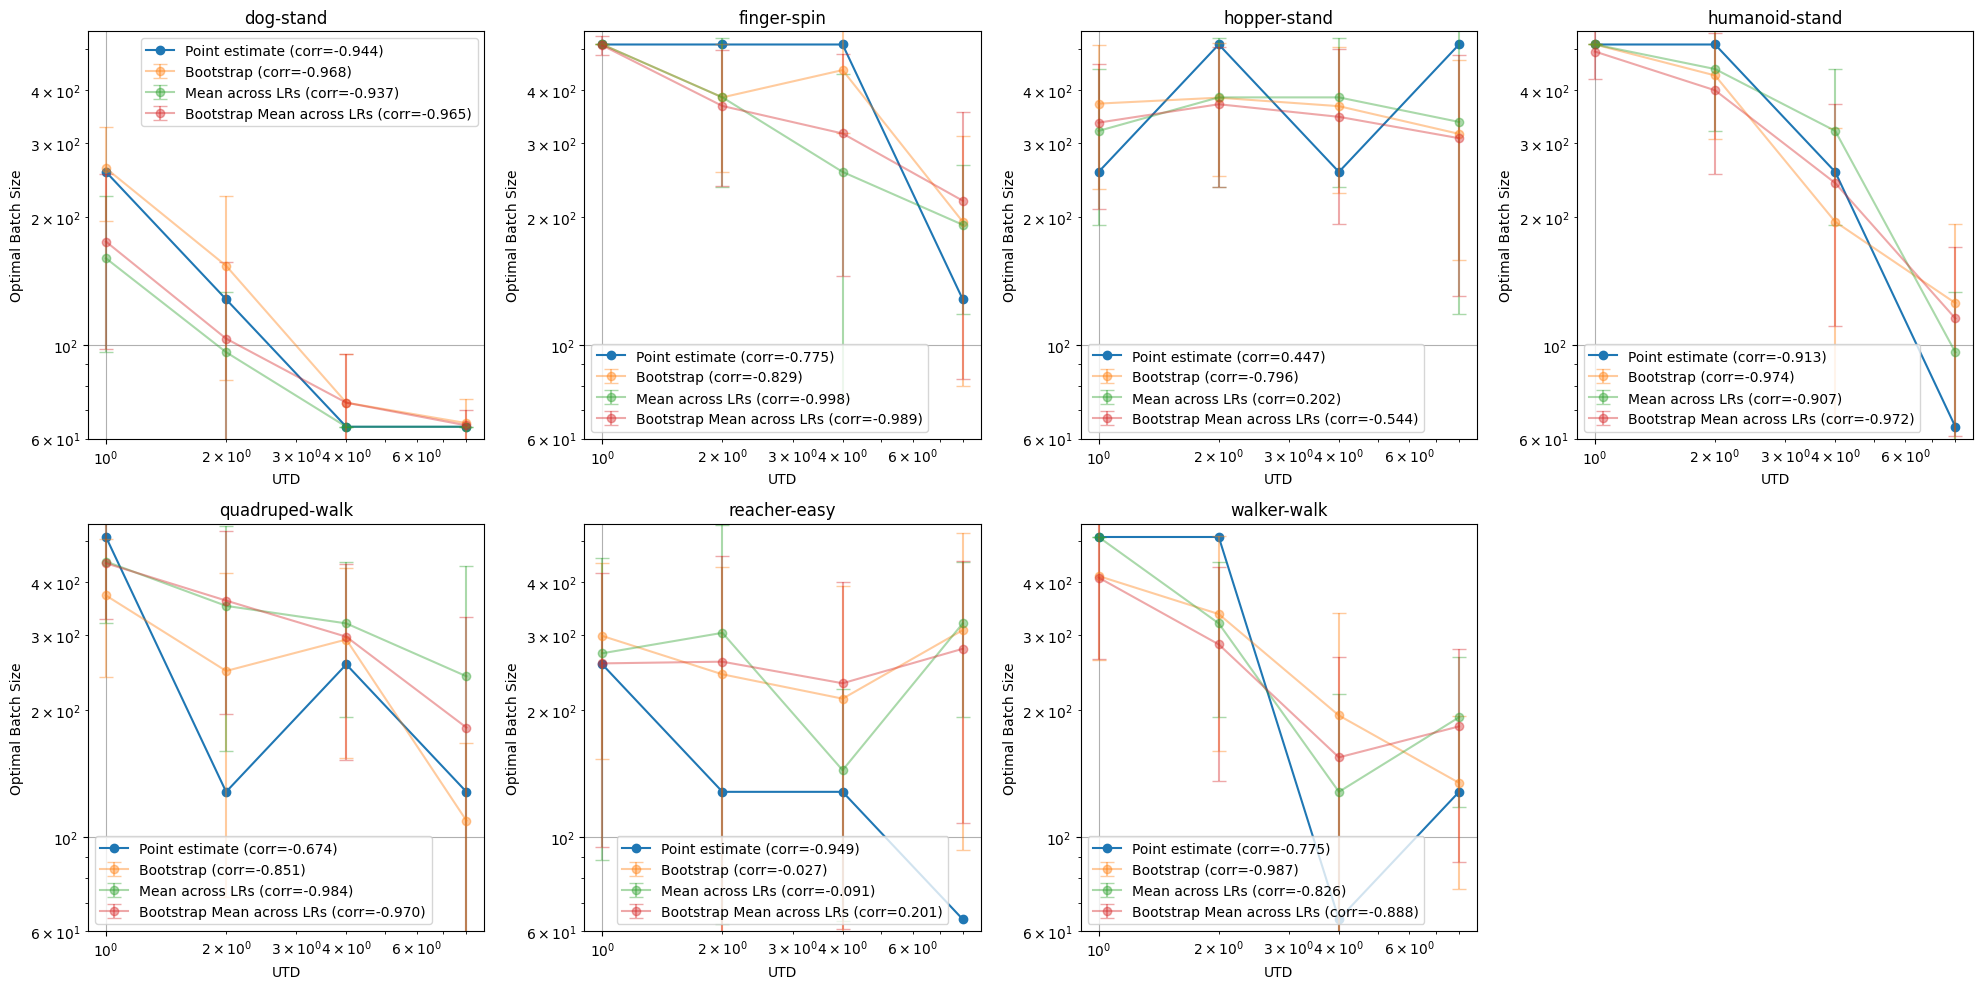

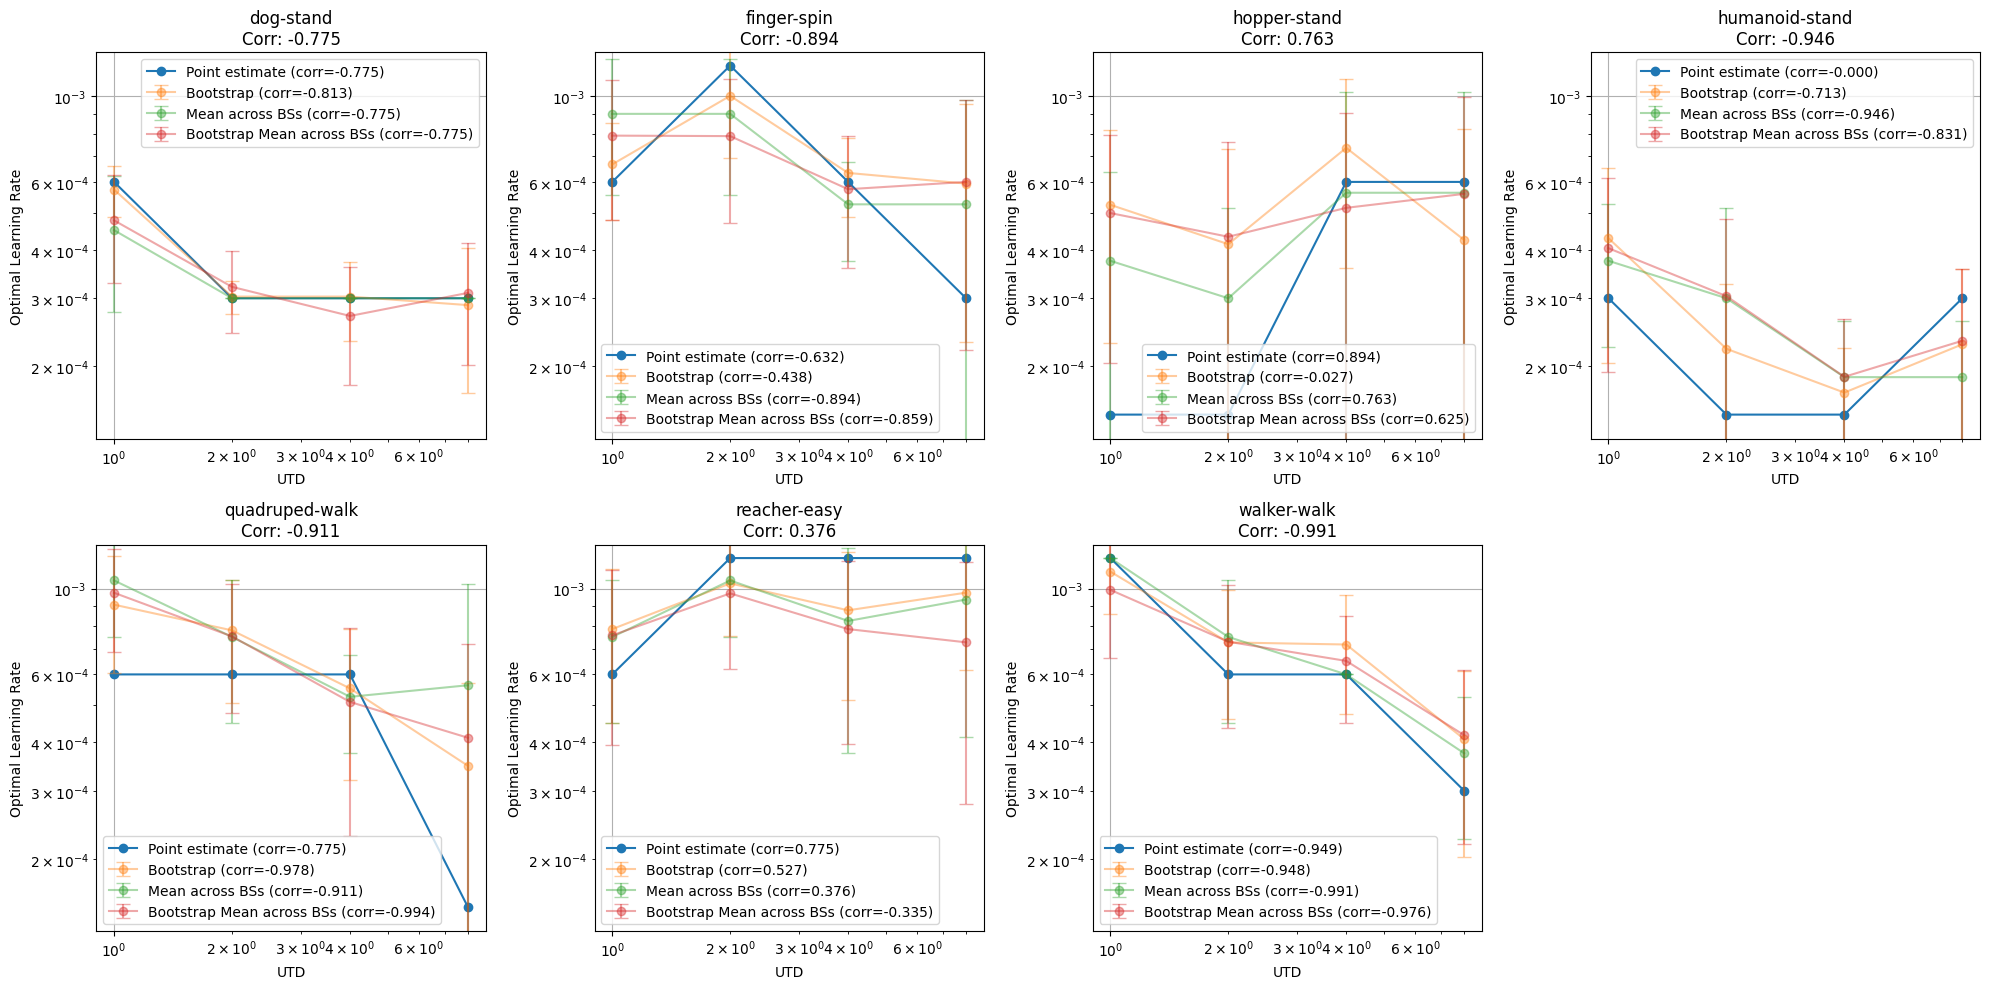

In [54]:
# plot hparams and performance for optimal bs, lr
envs = df_best_lr_bs['env_name'].unique()
n_envs = len(envs)

# Create first figure for batch size plots
fig1, axs1 = plt.subplots(2, 4, figsize=(20, 10))
axs1 = axs1.flatten()

# Plot 1: Optimal batch size vs UTD with bootstrap CIs and mean optimal batch size
for i, env in enumerate(envs):
    env_data = df_best_lr_bs[df_best_lr_bs['env_name'] == env]
    
    # Calculate correlation for point estimate
    point_bs_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_bs']))[0,1]
    axs1[i].plot(env_data['utd'], env_data['best_bs'], 'o-', label=f'Point estimate (corr={point_bs_corr:.3f})')
    
    # Add bootstrapped confidence intervals
    bootstrap_bs_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_bs_bootstrap_mean']))[0,1]
    axs1[i].errorbar(env_data['utd'], env_data['best_bs_bootstrap_mean'], 
                     yerr=env_data['best_bs_bootstrap_std'],
                     fmt='o-', capsize=5, alpha=0.4,
                     label=f'Bootstrap (corr={bootstrap_bs_corr:.3f})')
    
    # Add mean optimal batch size
    bs_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_bs_lrmean']))[0,1]
    axs1[i].errorbar(env_data['utd'], env_data['best_bs_lrmean'],
                     yerr=env_data['best_bs_lrmean_std'], 
                     fmt='o-', capsize=5, alpha=0.4,
                     label=f'Mean across LRs (corr={bs_corr:.3f})')
    
    # Add mean batch size averaged across learning rates and bootstrap intervals
    bs_corr_all = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_bs_bootstrap_lrmean']))[0,1]
    axs1[i].errorbar(env_data['utd'], env_data['best_bs_bootstrap_lrmean'],
                     yerr=env_data['best_bs_bootstrap_lrmean_std'],
                     fmt='o-', capsize=5, alpha=0.4,
                     label=f'Bootstrap Mean across LRs (corr={bs_corr_all:.3f})')
    
    axs1[i].set_xscale('log')
    axs1[i].set_yscale('log')
    axs1[i].set_xlabel('UTD')
    axs1[i].set_ylim(60, 550)
    axs1[i].set_ylabel('Optimal Batch Size')
    axs1[i].set_title(f'{env}')
    axs1[i].grid(True)
    axs1[i].legend()

# Remove empty subplots from first figure
for j in range(i+1, len(axs1)):
    fig1.delaxes(axs1[j])

plt.tight_layout()
plt.show()

# Create second figure for learning rate plots
fig2, axs2 = plt.subplots(2, 4, figsize=(20, 10))
axs2 = axs2.flatten()

# Plot 2: Optimal learning rate vs UTD with bootstrap CIs and mean optimal learning rate
for i, env in enumerate(envs):
    env_data = df_best_lr_bs[df_best_lr_bs['env_name'] == env]
    
    # Calculate correlation for point estimate
    point_lr_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_lr']))[0,1]
    axs2[i].plot(env_data['utd'], env_data['best_lr'], 'o-', label=f'Point estimate (corr={point_lr_corr:.3f})')
    
    # Add bootstrapped confidence intervals
    bootstrap_lr_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_lr_bootstrap_mean']))[0,1]
    axs2[i].errorbar(env_data['utd'], env_data['best_lr_bootstrap_mean'],
                     yerr=env_data['best_lr_bootstrap_std'],
                     fmt='o-', capsize=5, alpha=0.4,
                     label=f'Bootstrap (corr={bootstrap_lr_corr:.3f})')
    
    # Add mean optimal learning rate
    lr_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_lr_bsmean']))[0,1]
    axs2[i].errorbar(env_data['utd'], env_data['best_lr_bsmean'],
                     yerr=env_data['best_lr_bsmean_std'],
                     fmt='o-', capsize=5, alpha=0.4,
                     label=f'Mean across BSs (corr={lr_corr:.3f})')
    
    # Add mean learning rate averaged across batch sizes and bootstrap intervals
    lr_corr_all = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_lr_bootstrap_bsmean']))[0,1]
    axs2[i].errorbar(env_data['utd'], env_data['best_lr_bootstrap_bsmean'],
                     yerr=env_data['best_lr_bootstrap_bsmean_std'],
                     fmt='o-', capsize=5, alpha=0.4,
                     label=f'Bootstrap Mean across BSs (corr={lr_corr_all:.3f})')
    
    axs2[i].set_xscale('log')
    axs2[i].set_yscale('log')
    axs2[i].set_xlabel('UTD')
    axs2[i].set_ylim(1.3e-4, 1.3e-3)
    axs2[i].set_ylabel('Optimal Learning Rate')
    axs2[i].set_title(f'{env}\nCorr: {lr_corr:.3f}')
    axs2[i].grid(True)
    axs2[i].legend()

# Remove empty subplots from second figure
for j in range(i+1, len(axs2)):
    fig2.delaxes(axs2[j])

plt.tight_layout()
plt.show()


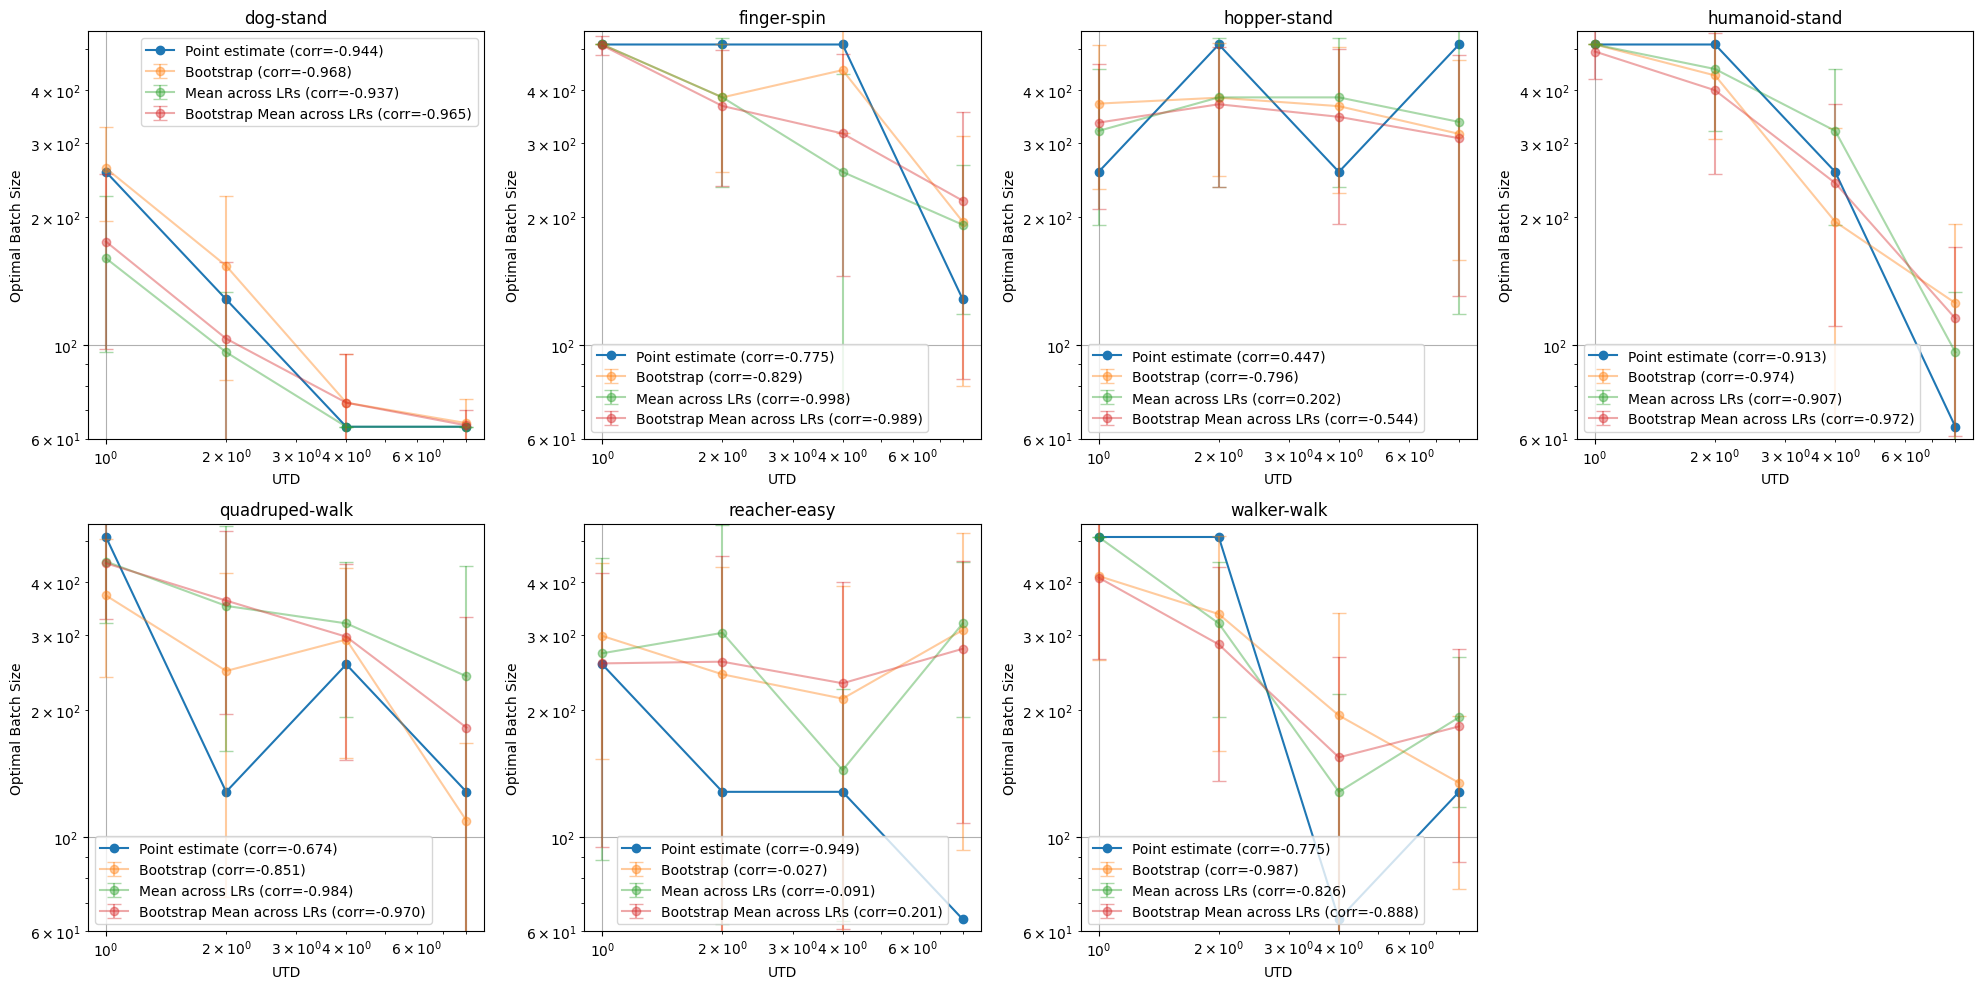

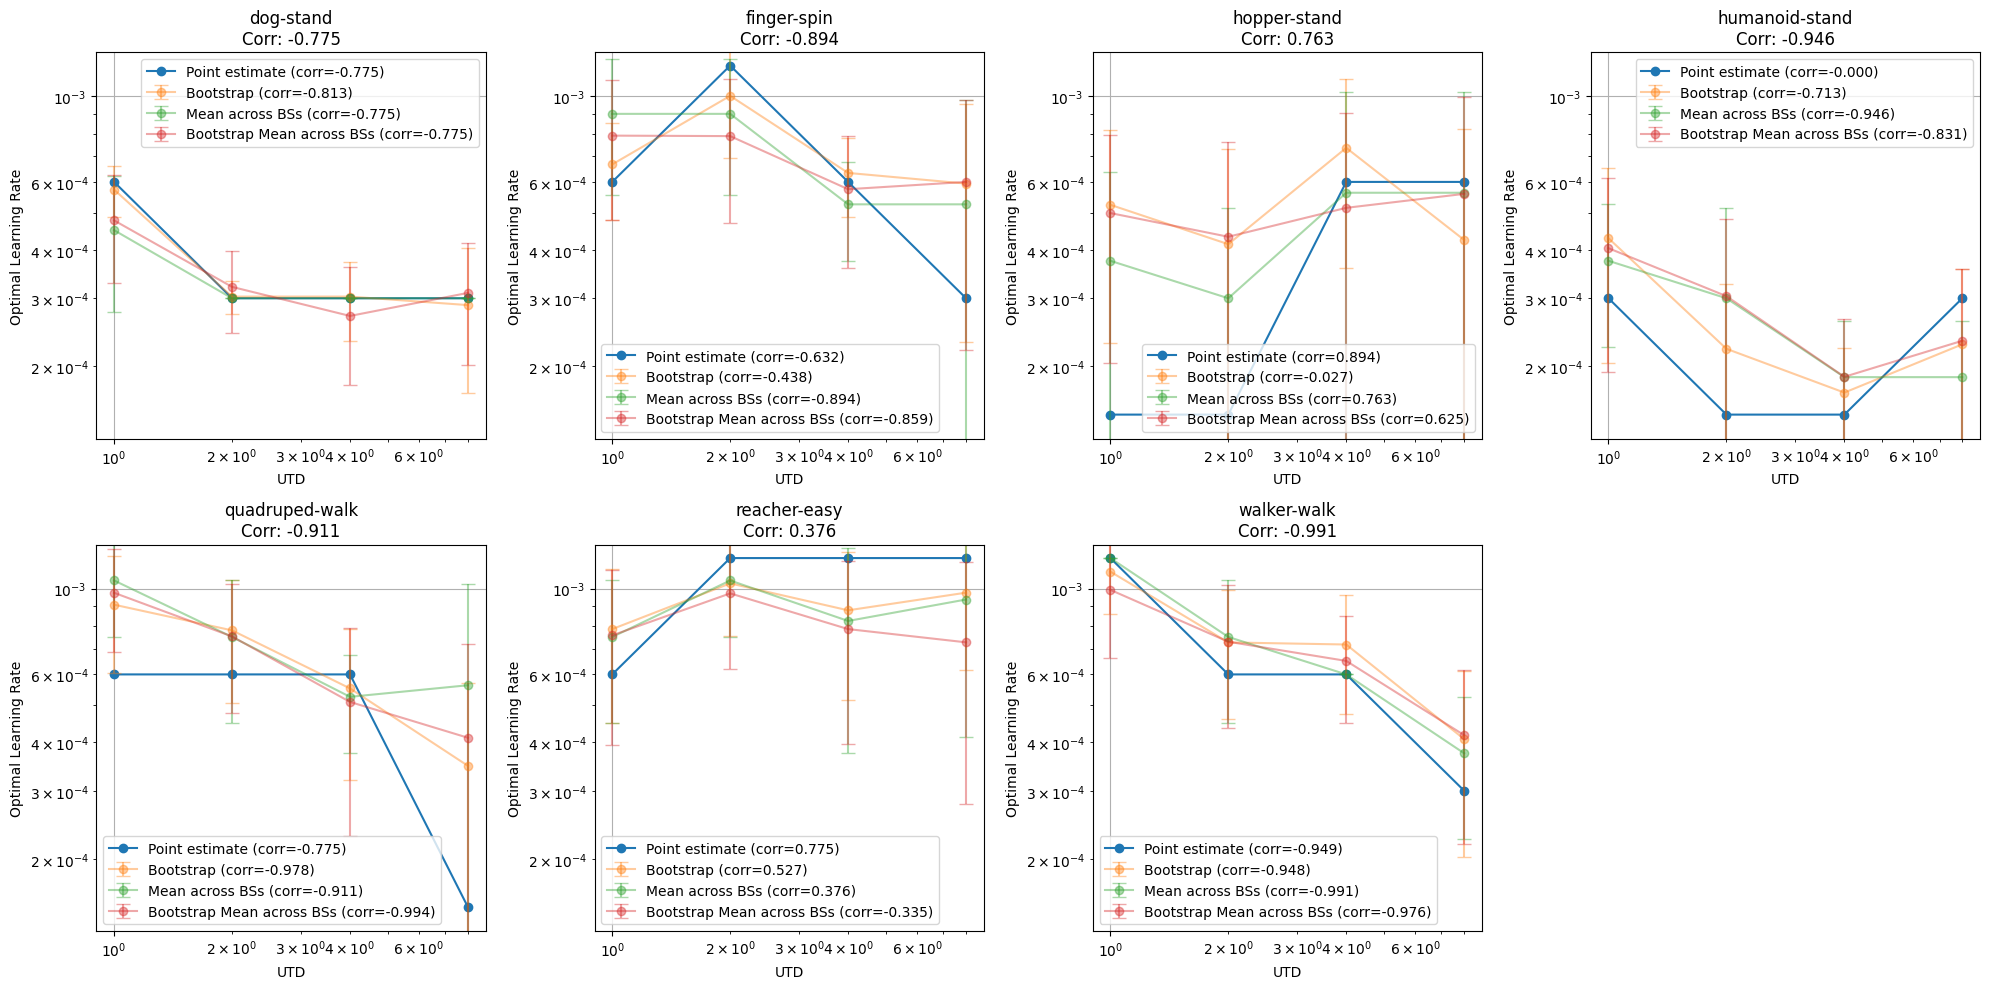

In [40]:
# plot hparams and performance for optimal bs, lr
envs = df_best_lr_bs['env_name'].unique()
n_envs = len(envs)

# Create first figure for batch size plots
fig1, axs1 = plt.subplots(2, 4, figsize=(20, 10))
axs1 = axs1.flatten()

# Plot 1: Optimal batch size vs UTD with bootstrap CIs and mean optimal batch size
for i, env in enumerate(envs):
    env_data = df_best_lr_bs[df_best_lr_bs['env_name'] == env]
    
    # Calculate correlation for point estimate
    point_bs_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_bs']))[0,1]
    axs1[i].plot(env_data['utd'], env_data['best_bs'], 'o-', label=f'Point estimate (corr={point_bs_corr:.3f})')
    
    # Add bootstrapped confidence intervals
    best_bs_bootstrap = np.stack(env_data['best_bs_bootstrap'].values)
    mean_bs_bootstrap = np.mean(best_bs_bootstrap, axis=1)
    std_bs_bootstrap = np.std(best_bs_bootstrap, axis=1)
    # Calculate correlation for bootstrap mean
    bootstrap_bs_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(mean_bs_bootstrap))[0,1]
    axs1[i].errorbar(env_data['utd'], mean_bs_bootstrap, yerr=std_bs_bootstrap, fmt='o-', capsize=5, alpha=0.4, 
                     label=f'Bootstrap (corr={bootstrap_bs_corr:.3f})')
    
    # Add mean optimal batch size
    env_data_mean = df_best_bs[df_best_bs['env_name'] == env]
    utd_groups = env_data_mean.groupby('utd')
    mean_bs = utd_groups['best_bs'].mean()
    std_bs = utd_groups['best_bs'].std()
    bs_corr = np.corrcoef(np.log10(mean_bs.index), np.log10(mean_bs.values))[0,1]
    axs1[i].errorbar(mean_bs.index, mean_bs.values, yerr=std_bs.values, fmt='o-', capsize=5, alpha=0.4, 
                     label=f'Mean across LRs (corr={bs_corr:.3f})')
    
    # Add mean batch size averaged across learning rates and bootstrap intervals
    env_data_mean = df_best_bs[df_best_bs['env_name'] == env].groupby('utd')
    best_bs_bootstrap = np.stack([np.stack(g['best_bs_bootstrap'].values) for _, g in utd_groups])
    mean_bs_all = np.mean(best_bs_bootstrap, axis=(1,2))
    std_bs_all = np.std(best_bs_bootstrap, axis=(1,2))
    bs_corr_all = np.corrcoef(np.log10(list(utd_groups.groups.keys())), np.log10(mean_bs_all))[0,1]
    axs1[i].errorbar(list(utd_groups.groups.keys()), mean_bs_all, yerr=std_bs_all, fmt='o-', capsize=5, alpha=0.4,
                     label=f'Bootstrap Mean across LRs (corr={bs_corr_all:.3f})')
    
    axs1[i].set_xscale('log')
    axs1[i].set_yscale('log')
    axs1[i].set_xlabel('UTD')
    axs1[i].set_ylim(60, 550)
    axs1[i].set_ylabel('Optimal Batch Size')
    axs1[i].set_title(f'{env}')
    axs1[i].grid(True)
    axs1[i].legend()

# Remove empty subplots from first figure
for j in range(i+1, len(axs1)):
    fig1.delaxes(axs1[j])

plt.tight_layout()
plt.show()


# Create second figure for learning rate plots
fig2, axs2 = plt.subplots(2, 4, figsize=(20, 10))
axs2 = axs2.flatten()

# Plot 2: Optimal learning rate vs UTD with bootstrap CIs and mean optimal learning rate
for i, env in enumerate(envs):
    env_data = df_best_lr_bs[df_best_lr_bs['env_name'] == env]
    
    # Calculate correlation for point estimate
    point_lr_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(env_data['best_lr']))[0,1]
    axs2[i].plot(env_data['utd'], env_data['best_lr'], 'o-', label=f'Point estimate (corr={point_lr_corr:.3f})')
    
    # Add bootstrapped confidence intervals
    best_lr_bootstrap = np.stack(env_data['best_lr_bootstrap'].values)
    mean_lr_bootstrap = np.mean(best_lr_bootstrap, axis=1)
    std_lr_bootstrap = np.std(best_lr_bootstrap, axis=1)
    # Calculate correlation for bootstrap mean
    bootstrap_lr_corr = np.corrcoef(np.log10(env_data['utd']), np.log10(mean_lr_bootstrap))[0,1]
    axs2[i].errorbar(env_data['utd'], mean_lr_bootstrap, yerr=std_lr_bootstrap, fmt='o-', capsize=5, alpha=0.4, 
                     label=f'Bootstrap (corr={bootstrap_lr_corr:.3f})')
    
    # Add mean optimal learning rate
    env_data_mean = df_best_lr[df_best_lr['env_name'] == env]
    utd_groups = env_data_mean.groupby('utd')
    mean_lr = utd_groups['best_lr'].mean()
    std_lr = utd_groups['best_lr'].std()
    lr_corr = np.corrcoef(np.log10(mean_lr.index), np.log10(mean_lr.values))[0,1]
    axs2[i].errorbar(mean_lr.index, mean_lr.values, yerr=std_lr.values, fmt='o-', capsize=5, alpha=0.4, 
                     label=f'Mean across BSs (corr={lr_corr:.3f})')
    
    # Add mean learning rate averaged across batch sizes and bootstrap intervals
    env_data_mean = df_best_lr[df_best_lr['env_name'] == env].groupby('utd')
    best_lr_bootstrap = np.stack([np.stack(g['best_lr_bootstrap'].values) for _, g in utd_groups])
    mean_lr_all = np.mean(best_lr_bootstrap, axis=(1,2))
    std_lr_all = np.std(best_lr_bootstrap, axis=(1,2))
    lr_corr_all = np.corrcoef(np.log10(list(utd_groups.groups.keys())), np.log10(mean_lr_all))[0,1]
    axs2[i].errorbar(list(utd_groups.groups.keys()), mean_lr_all, yerr=std_lr_all, fmt='o-', capsize=5, alpha=0.4,
                     label=f'Bootstrap Mean across BSs (corr={lr_corr_all:.3f})')
    
    axs2[i].set_xscale('log')
    axs2[i].set_yscale('log')
    axs2[i].set_xlabel('UTD')
    axs2[i].set_ylim(1.3e-4, 1.3e-3)
    axs2[i].set_ylabel('Optimal Learning Rate')
    axs2[i].set_title(f'{env}\nCorr: {lr_corr:.3f}')
    axs2[i].grid(True)
    axs2[i].legend()

# Remove empty subplots from second figure
for j in range(i+1, len(axs2)):
    fig2.delaxes(axs2[j])

plt.tight_layout()
plt.show()


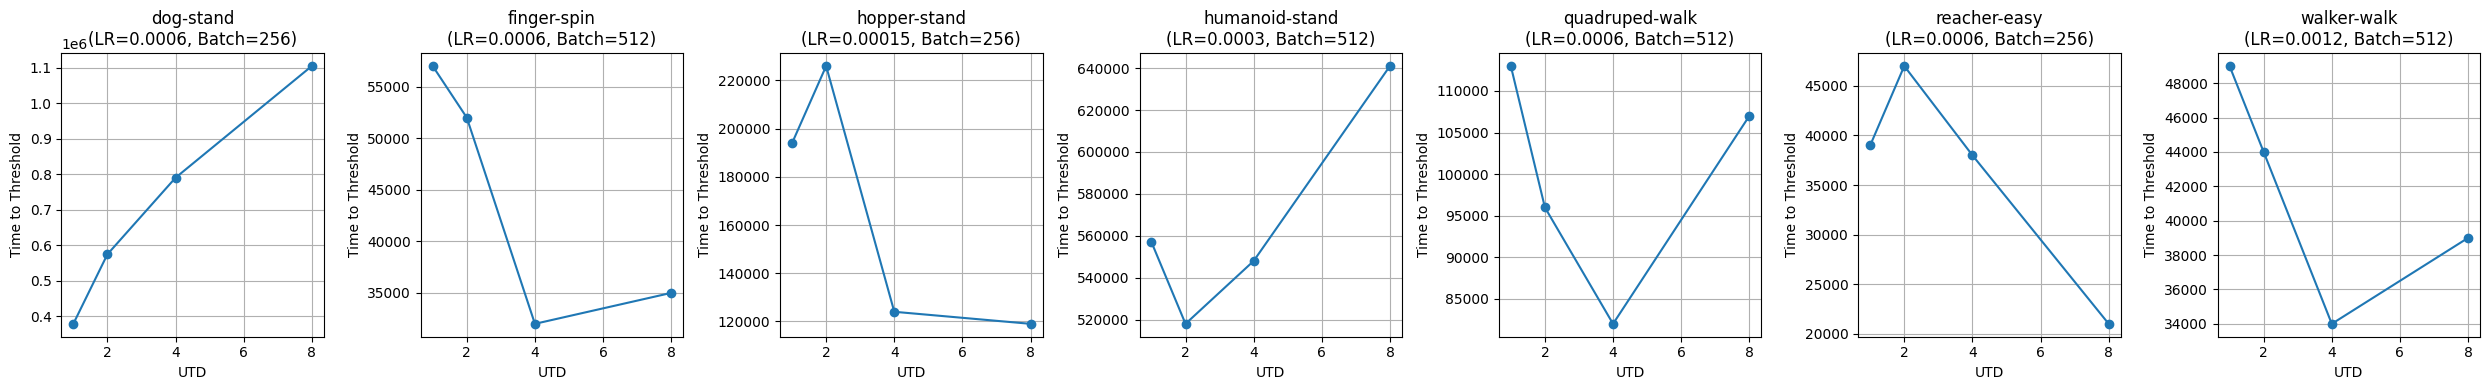

In [43]:
# Plot time to threshold for each environment using subplots
n_envs = len(envs)

fig, axs = plt.subplots(1, 7, figsize=(25, 4))
axs = axs.flatten()

for i, env in enumerate(envs):
    # Get optimal learning rate and batch size for UTD=1 for this env
    utd_1_data = df_best_lr_bs[(df_best_lr_bs['utd'] == 1) & 
                                 (df_best_bs['env_name'] == env)]
    utd_1_lr = utd_1_data['best_lr'].values[0]
    utd_1_batch = utd_1_data['batch_size'].values[0]

    # Filter data for UTD=1 learning rate and batch size for this env
    df_utd1 = df[
        (df['learning_rate'] == utd_1_lr) & 
        (df['batch_size'] == utd_1_batch) &
        (df['env_name'] == env)
    ]

    # Sort by UTD values
    df_utd1_sorted = df_utd1.sort_values('utd')

    axs[i].plot(df_utd1_sorted['utd'], [x[-1] for x in df_utd1_sorted['crossings'].values], 'o-')
    axs[i].set_xlabel('UTD')
    axs[i].set_ylabel('Time to Threshold')
    axs[i].set_title(f'{env}\n(LR={utd_1_lr}, Batch={utd_1_batch})')
    axs[i].grid(True)

# Remove empty subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()



## Old

  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 125/125 [00:01<00:00, 90.01it/s]


loss 0.007633970780512636
y = 8.77e+00 / (1 + x/2.57e-03)^-2.62e-01


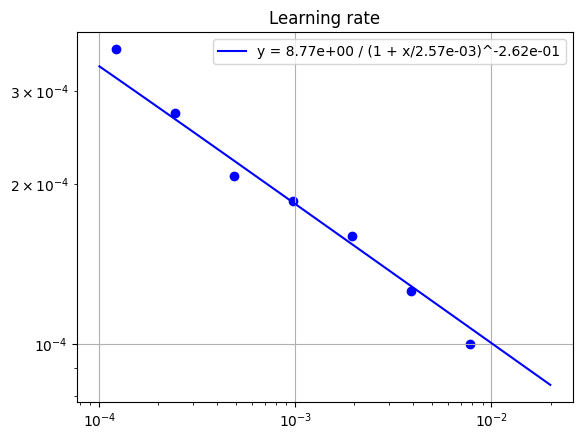

In [146]:
# large-batch training - fit() - uncertainty-corrected

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((lr_rule(x,a,b,c) - y) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def lr_rule(x, a, b, c):
    return c * (1 + x/b) ** (-a)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768, 65536])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4, 3.7e-4])
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 1.86e-4, 2.07e-4, 2.73e-4, 3.6e-4]) # uncertainty corrected
fit_data_points = [3, 4, 5, 6]
plot_data_points = [1, 2, 3, 4, 5, 6, 7]
tried_values = [[4e-5], [1e-4, 2e-4], [1.26e-4, 1e-4, 2e-4], [1.6e-4, 1e-4, 2e-4], [2e-4, 1e-4], [2e-4, 2.5e-4, 3.2e-4], [2.5e-4, 2e-4], [3.2e-4, 2.7e-4, 3.7e-4]]

scaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 1.3, 100)
y_fitted = lr_rule(x_smooth, a, b, c)

# for i, lr_tried in enumerate(tried_values):
#     if i in plot_data_points:
#         plt.scatter([utd[i]]*len(lr_tried), lr_tried, color='lightblue')    
plt.title('Learning rate')
plt.scatter(utd[plot_data_points], learning_rate[plot_data_points], color='blue')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
# Extrapolate

def get_lr(n_parallel):
    utd = 8/n_parallel * scaling[0]  # Scale UTD ratio same as training data
    predicted_lr = lr_rule(utd, a, b, c) / scaling[1]  # Unscale the prediction
    return predicted_lr

print(f'Predicted learning rate for n_parallel=131072: {get_lr(131072):.2e}')
print(f'Predicted learning rate for n_parallel=65536: {get_lr(65536):.2e}')
print(f'Predicted learning rate for n_parallel=32768: {get_lr(32768):.2e}')


Predicted learning rate for n_parallel=131072: 3.78e-04
Predicted learning rate for n_parallel=65536: 3.18e-04
Predicted learning rate for n_parallel=32768: 2.67e-04


  0%|          | 0/125 [00:00<?, ?it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 125/125 [00:01<00:00, 104.89it/s]


loss 0.0025927195200633993



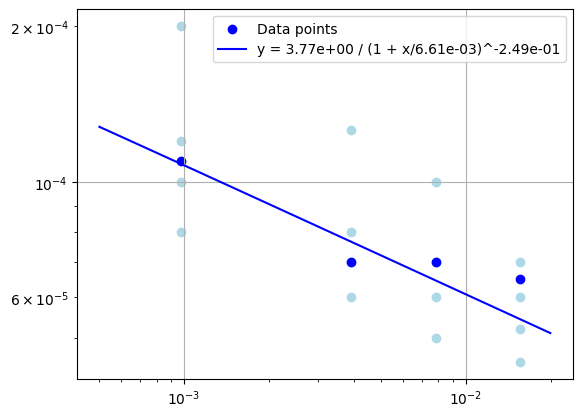

In [8]:
# Pushing, 2x width - fit


n_parallel = np.array([512, 1024, 2048, 8192])
utd = 1/n_parallel * 8
learning_rate = np.array([6e-5, 7e-5, 7e-5, 1e-4])
learning_rate = np.array([6.5e-5, 7e-5, 7e-5, 1.1e-4]) # uncertainty corrected
fit_data_points = [1, 2, 3]
plot_data_points = [0, 1, 2, 3]
lr_tried_values = [[6e-5, 7e-5], [5e-5, 1e-4], [6e-5, 1.26e-4], [1e-4, 2e-4]]
lr_tried_values = [[5.2e-5, 4.5e-5, 6e-5, 7e-5], [5e-5, 6e-5, 7e-5, 1e-4], [6e-5, 7e-5, 8e-5, 1.26e-4], [1.2e-4, 8e-5, 1e-4, 2e-4]] # values to try

scaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-0.3, 1.3, 100)
y_fitted = lr_rule(x_smooth, a, b, c)

for i, lr_tried in enumerate(lr_tried_values):
    plt.scatter([utd[i]]*len(lr_tried), lr_tried, color='lightblue')
plt.scatter(utd[plot_data_points], learning_rate[plot_data_points], color='blue', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
print()
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [70]:
# Extrapolate

def get_lr(n_parallel):
    utd = 8/n_parallel * scaling[0]  # Scale UTD ratio same as training data
    predicted_lr = lr_rule(utd, a, b, c) / scaling[1]  # Unscale the prediction
    return predicted_lr

print(f'Predicted learning rate for n_parallel=256: {get_lr(256):.2e}')
print(f'Predicted learning rate for n_parallel=512: {get_lr(512):.2e}')
print(f'Predicted learning rate for n_parallel=1024: {get_lr(1024):.2e}')
print(f'Predicted learning rate for n_parallel=2048: {get_lr(2048):.2e}')
print(f'Predicted learning rate for n_parallel=4096: {get_lr(4096):.2e}')
print(f'Predicted learning rate for n_parallel=8192: {get_lr(8192):.2e}')


Predicted learning rate for n_parallel=256: 4.49e-05
Predicted learning rate for n_parallel=512: 5.24e-05
Predicted learning rate for n_parallel=1024: 6.12e-05
Predicted learning rate for n_parallel=2048: 7.14e-05
Predicted learning rate for n_parallel=4096: 8.33e-05
Predicted learning rate for n_parallel=8192: 9.73e-05


27.472123918445998
0.0021486636720810383 loss
y = -1.73e+00 + (x/2.73e+04)^-1.24e-01


/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


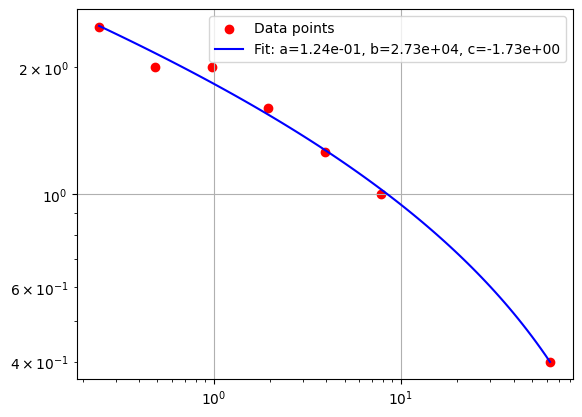

In [14]:
# learning rate - minimize()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])/1000
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4]) * 10000

optim_f = power_law_with_const_min
current_params = [-2.50000000e+00,  4.75000000e+00,  1e-04]
print(optim_f(current_params, utd, learning_rate))
lbfgs_pred = scipy.optimize.minimize(optim_f, current_params, args=((utd,), learning_rate), method='L-BFGS-B', tol=1e-10).x
# print(lbfgs_pred)
print(optim_f(lbfgs_pred, utd, learning_rate), 'loss')

# Plot the fit
x_smooth = np.logspace(np.log10(np.min(utd)), np.log10(np.max(utd)), 100)
y_fitted = power_law_with_const(x_smooth, *lbfgs_pred)

plt.figure()
plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth, y_fitted, 'b-', label=f'Fit: a={lbfgs_pred[0]:.2e}, b={lbfgs_pred[1]:.2e}, c={lbfgs_pred[2]:.2e}')
print(f'y = {lbfgs_pred[2]:.2e} + (x/{lbfgs_pred[1]:.2e})^-{lbfgs_pred[0]:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



  6%|▋         | 8/125 [00:00<00:03, 36.07it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
 26%|██▋       | 33/125 [00:00<00:01, 47.86it/s]/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
100%|██████████| 125/125 [00:02<00:00, 52.97it/s]


0.002654084755498555 loss
y = -1.30e+00 + (x/2.80e+03)^-1.43e-01


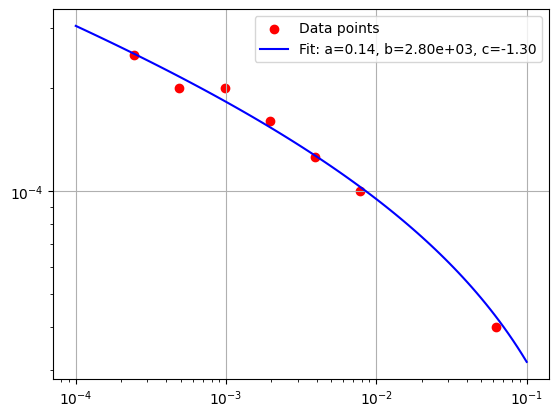

In [21]:
# learning rate - fit()

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

rescaling = [1000, 10000]
fitted_params = fit(utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1], power_law_with_const_min,
                     [slice(-4, 4, 1.6),slice(1, 10, 2),slice(1e-5, 5e-4, 1e-4)], disp=False, maxiter=100)
print(power_law_with_const_min(fitted_params, utd[fit_data_points] * rescaling[0], learning_rate[fit_data_points] * rescaling[1]), 'loss')

x_smooth = np.logspace(-1, 2, 100)
a, b, c = fitted_params
y_fitted = power_law_with_const(x_smooth, a, b, c)

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / rescaling[0], y_fitted / rescaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} + (x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/oleh/miniconda3/envs/rlgpu/lib/python3.7/sit

loss 0.41987349469597063
y = 2.00e+00 / (1 + x/1.09e-05)^-8.00e-01


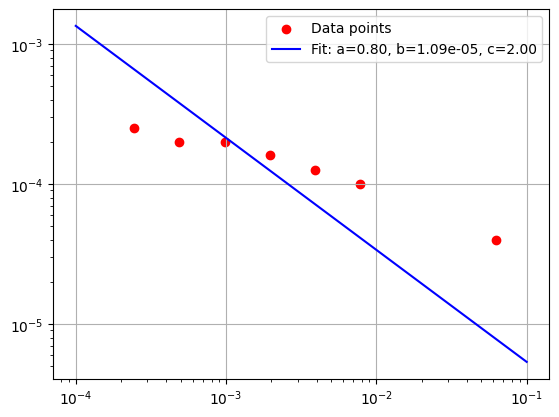

In [30]:
# large-batch training - log space - fit()

def lr_rule_min(args, *params):
    x,y = params
    a,b,c = args
    return ((log_lr_rule(x,a,b,c) - np.log(y)) ** 2).mean()
    # return ((np.log(lr_rule(x,a,b,c) / y)) ** 2).mean()

def log_lr_rule(x, a, b, c):
    return np.log(c) - a * np.log(1 + x/b)

n_parallel = np.array([128, 1024, 2048, 4096, 8192, 16384, 32768])
utd = 1/n_parallel * 8
learning_rate = np.array([4e-5, 1e-4, 1.26e-4, 1.6e-4, 2e-4, 2e-4, 2.5e-4])
fit_data_points = [1, 2, 3, 4, 5, 6]

scaling = [1000, 1]
fitted_params = fit(utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1], lr_rule_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', lr_rule_min(fitted_params, utd[fit_data_points] * scaling[0], learning_rate[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 2, 100)
y_fitted = np.exp(log_lr_rule(x_smooth, a, b, c))

plt.scatter(utd, learning_rate, color='red', label='Data points')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'Fit: a={a:.2f}, b={b:.2e}, c={c:.2f}')
print(f'y = {c:.2e} / (1 + x/{b:.2e})^-{a:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
daily_prob = 1e-2
total_days = 8 * 365 / 3
total_prob = 1 - (1 - daily_prob) ** total_days
total_prob


0.9999435596876843